In [114]:
%matplotlib inline
import arviz as az # v 0.15.1
import matplotlib.pyplot as plt # v 3.7.1
from sklearn.metrics import mean_squared_error # v 1.2.2
import numpy as np # v 1.23.5
import pymc as pm # v 5.7.2
from scipy import stats # v 1.11.4
from scipy.special import erf # 1.11.4
import pandas as pd # v 1.5.3
import seaborn as sns # v 0.12.2
from sklearn.preprocessing import StandardScaler # v 1.2.2

In [115]:
az.style.use('arviz-darkgrid')
random_seed = 1234

## Data Importing and Cleaning

We read in the dataframe.

In [116]:
fires = pd.read_csv('Algerian_forest_fires_dataset_UPDATE.csv', skiprows=1)

We rename the columns to remove whitespace.

In [117]:
fires.rename(columns = {"Rain ":"Rain", " RH":"RH", " Ws":"Ws", "Classes  ": "Classes"}, inplace=True)

The two tables of the two regions were provided in two tables in a single CSV file. The below code identifies which row was the split between the two regions within the dataset.

In [118]:
fires.iloc[122:124,:]

day  month  year  Temperature   RH   Ws   Rain  \
122  Sidi-Bel Abbes Region Dataset    NaN   NaN          NaN  NaN  NaN    NaN   
123                            day  month  year  Temperature   RH   Ws  Rain    

     FFMC  DMC   DC  ISI  BUI  FWI    Classes  
122   NaN  NaN  NaN  NaN  NaN  NaN        NaN  
123  FFMC  DMC   DC  ISI  BUI  FWI  Classes

We create region based on which regional dataset each row was in and add a dummy variable 1 if "Bejaia" and 0 if "Sidi-Bel".

In [119]:
fires['region'] = ["Bejaia" if x < 124 else "Sidi-Bel" for x in range(fires.shape[0])]

In [120]:
fires['region_dummy'] = [0 if x < 124 else 1 for x in range(fires.shape[0])]

Here we drop the two rows in the dataset that correspond to the header in the CSV for the Sidi-Bel region. Additionally, we drop the year column as the entirety of observations in our data take place in 2012.

In [121]:
fires.drop([122, 123], inplace=True)
fires.drop(['year'], axis=1, inplace=True)

We check the data type of each feature.

In [122]:
fires.dtypes

day             object
month           object
Temperature     object
RH              object
Ws              object
Rain            object
FFMC            object
DMC             object
DC              object
ISI             object
BUI             object
FWI             object
Classes         object
region          object
region_dummy     int64
dtype: object

We create a list of the numeric columns and then convert them into type 'numeric'. For Class we made it a 'categorical' variable.

In [123]:
numeric_columns = ['day', 'month', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
fires[numeric_columns] = fires[numeric_columns].apply(pd.to_numeric, errors='coerce')

fires['Classes'] = fires['Classes'].astype('category')

We noticed one of the rows had an issue were the CSV was loaded without the deliniating ',' for one observation. We manually code in these values to represent the observation correctly.

In [124]:
fires.loc[167, 'DMC'] = 12.9
fires.loc[167, 'DC'] = 14.6
fires.loc[167, 'ISI'] = 9
fires.loc[167, 'BUI'] = 12.5
fires.loc[167, 'FWI'] = 10.4
fires.loc[167, 'Classes'] = 'fire'

In [125]:
fires.loc[167]

day                   14
month                  7
Temperature           37
RH                    37
Ws                    18
Rain                 0.2
FFMC                88.9
DMC                 12.9
DC                  14.6
ISI                  9.0
BUI                 12.5
FWI                 10.4
Classes             fire
region          Sidi-Bel
region_dummy           1
Name: 167, dtype: object

We checked Classes to ensure it was the binary outcome we expected and we see there is some whitespace which prevents it from being a binary class.

In [126]:
fires['Classes'].unique()

['not fire   ', 'fire   ', 'fire', 'fire ', 'not fire', 'not fire ', 'not fire     ', 'not fire    ']
Categories (8, object): ['fire', 'fire ', 'fire   ', 'not fire', 'not fire ', 'not fire   ',
                         'not fire    ', 'not fire     ']

We remove the whitespace to make the class binary, and then code a dummy variable.

In [127]:
fires['Classes'] = fires['Classes'].str.replace(' ', '')

In [128]:
fires['Classes_binary'] = np.where(fires['Classes'] == 'fire', 1, 0)

## EDA

Below we get a high level description of each field.

In [129]:
fires.describe(include='all')

day       month  Temperature          RH          Ws  \
count   244.000000  244.000000   244.000000  244.000000  244.000000   
unique         NaN         NaN          NaN         NaN         NaN   
top            NaN         NaN          NaN         NaN         NaN   
freq           NaN         NaN          NaN         NaN         NaN   
mean     15.754098    7.500000    32.172131   61.938525   15.504098   
std       8.825059    1.112961     3.633843   14.884200    2.810178   
min       1.000000    6.000000    22.000000   21.000000    6.000000   
25%       8.000000    7.000000    30.000000   52.000000   14.000000   
50%      16.000000    7.500000    32.000000   63.000000   15.000000   
75%      23.000000    8.000000    35.000000   73.250000   17.000000   
max      31.000000    9.000000    42.000000   90.000000   29.000000   

              Rain        FFMC         DMC          DC         ISI  \
count   244.000000  244.000000  244.000000  244.000000  244.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean      0.760656   77.887705   14.673361   49.288115    4.759836   
std       1.999406   14.337571   12.368039   47.619662    4.154628   
min       0.000000   28.600000    0.700000    6.900000    0.000000   
25%       0.000000   72.075000    5.800000   13.275000    1.400000   
50%       0.000000   83.500000   11.300000   33.100000    3.500000   
75%       0.500000   88.300000   20.750000   68.150000    7.300000   
max      16.800000   96.000000   65.900000  220.400000   19.000000   

               BUI         FWI Classes  region  region_dummy  Classes_binary  
count   244.000000  244.000000     244     244    244.000000      244.000000  
unique         NaN         NaN       2       2           NaN             NaN  
top            NaN         NaN    fire  Bejaia           NaN             NaN  
freq           NaN         NaN     138     122           NaN             NaN  
mean     16.673361    7.049180     NaN     NaN      0.500000        0.565574  
std      14.201648    7.428366     NaN     NaN      0.501028        0.496700  
min       1.100000    0.000000     NaN     NaN      0.000000        0.000000  
25%       6.000000    0.700000     NaN     NaN      0.000000        0.000000  
50%      12.450000    4.450000     NaN     NaN      0.500000        1.000000  
75%      22.525000   11.375000     NaN     NaN      1.000000        1.000000  
max      68.000000   31.100000     NaN     NaN      1.000000        1.000000

Below is the correlation matrix for the features and a heatmap of the correlations. We see there are a number of features that are highly correlated. This makes sense given all the features are some combination of the four weather predictors Wind, Temperature, Relative Humidity, Wind Speed.

In [130]:
corr = fires.corr().round(3)
corr

<ipython-input-130-19beb688faf4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = fires.corr().round(3)


day  month  Temperature     RH     Ws   Rain   FFMC    DMC  \
day             1.000  0.000        0.096 -0.074  0.047 -0.112  0.224  0.492   
month           0.000  1.000       -0.059 -0.038 -0.041  0.035  0.016  0.068   
Temperature     0.096 -0.059        1.000 -0.654 -0.278 -0.327  0.677  0.483   
RH             -0.074 -0.038       -0.654  1.000  0.236  0.223 -0.646 -0.405   
Ws              0.047 -0.041       -0.278  0.236  1.000  0.170 -0.163 -0.001   
Rain           -0.112  0.035       -0.327  0.223  0.170  1.000 -0.544 -0.289   
FFMC            0.224  0.016        0.677 -0.646 -0.163 -0.544  1.000  0.602   
DMC             0.492  0.068        0.483 -0.405 -0.001 -0.289  0.602  1.000   
DC              0.528  0.128        0.370 -0.220  0.076 -0.297  0.504  0.875   
ISI             0.179  0.064        0.606 -0.688  0.012 -0.348  0.741  0.678   
BUI             0.517  0.086        0.456 -0.350  0.030 -0.299  0.590  0.982   
FWI             0.350  0.082        0.567 -0.580  0.034 -0.325  0.691  0.875   
region_dummy    0.000 -0.000        0.273 -0.406 -0.177 -0.041  0.225  0.191   
Classes_binary  0.202  0.022        0.518 -0.435 -0.067 -0.379  0.770  0.584   

                   DC    ISI    BUI    FWI  region_dummy  Classes_binary  
day             0.528  0.179  0.517  0.350         0.000           0.202  
month           0.128  0.064  0.086  0.082        -0.000           0.022  
Temperature     0.370  0.606  0.456  0.567         0.273           0.518  
RH             -0.220 -0.688 -0.350 -0.580        -0.406          -0.435  
Ws              0.076  0.012  0.030  0.034        -0.177          -0.067  
Rain           -0.297 -0.348 -0.299 -0.325        -0.041          -0.379  
FFMC            0.504  0.741  0.590  0.691         0.225           0.770  
DMC             0.875  0.678  0.982  0.875         0.191           0.584  
DC              1.000  0.504  0.942  0.737        -0.081           0.507  
ISI             0.504  1.000  0.641  0.922         0.266           0.736  
BUI             0.942  0.641  1.000  0.857         0.088           0.585  
FWI             0.737  0.922  0.857  1.000         0.198           0.719  
region_dummy   -0.081  0.266  0.088  0.198         1.000           0.165  
Classes_binary  0.507  0.736  0.585  0.719         0.165           1.000

<Axes: >

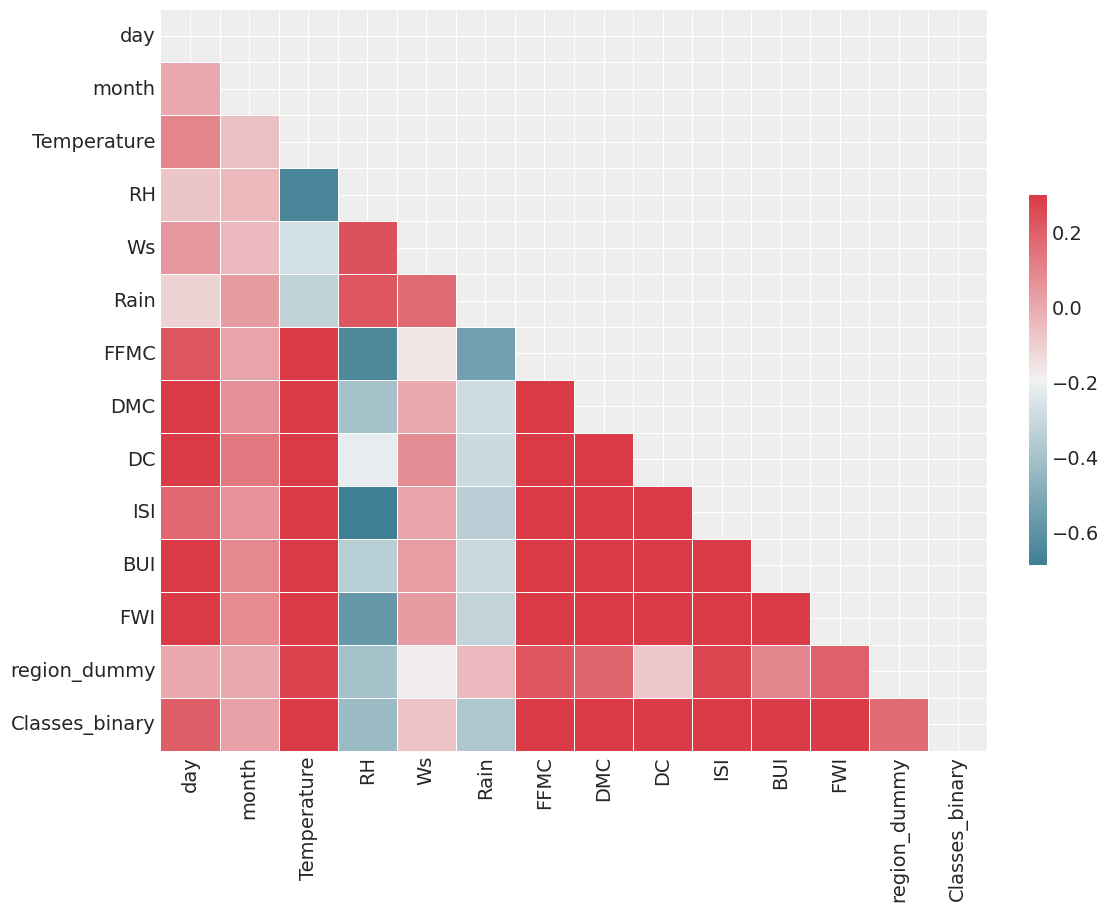

In [131]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
corr,
mask=mask,
cmap=cmap,
vmax=0.3,
linewidths=0.5,
cbar_kws={"shrink": 0.5},
ax=ax,
)

Below we looked at the distribution of the features.

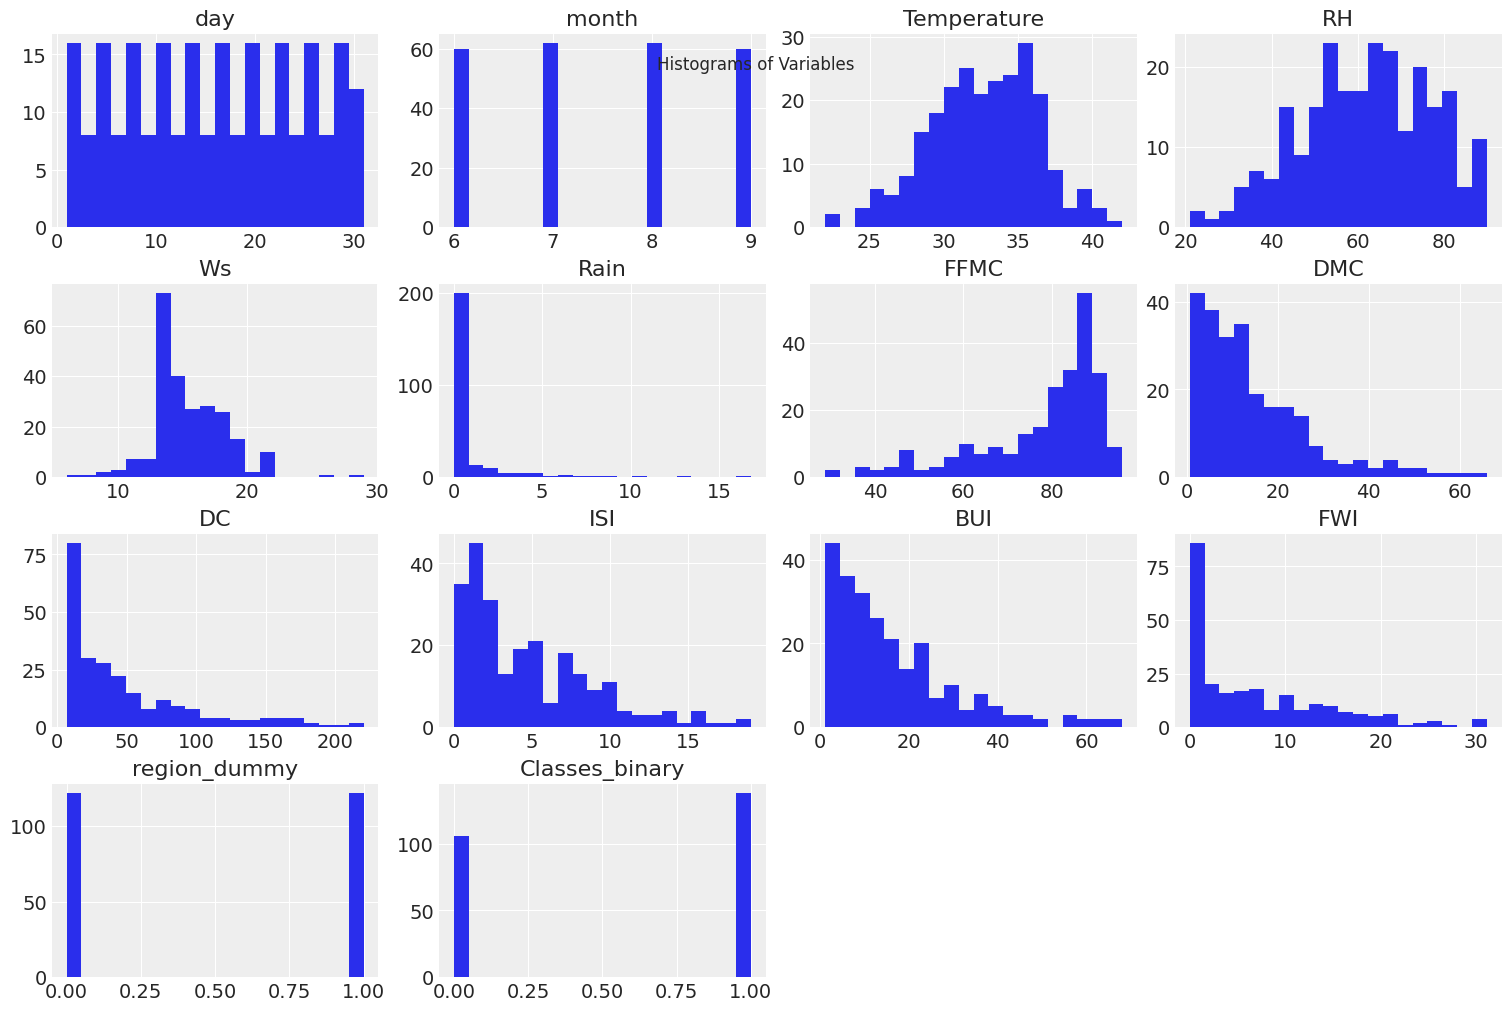

In [132]:
fires.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Variables', y=0.95)
plt.show()

Below is the pairplot showing the relation of the features with one another.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


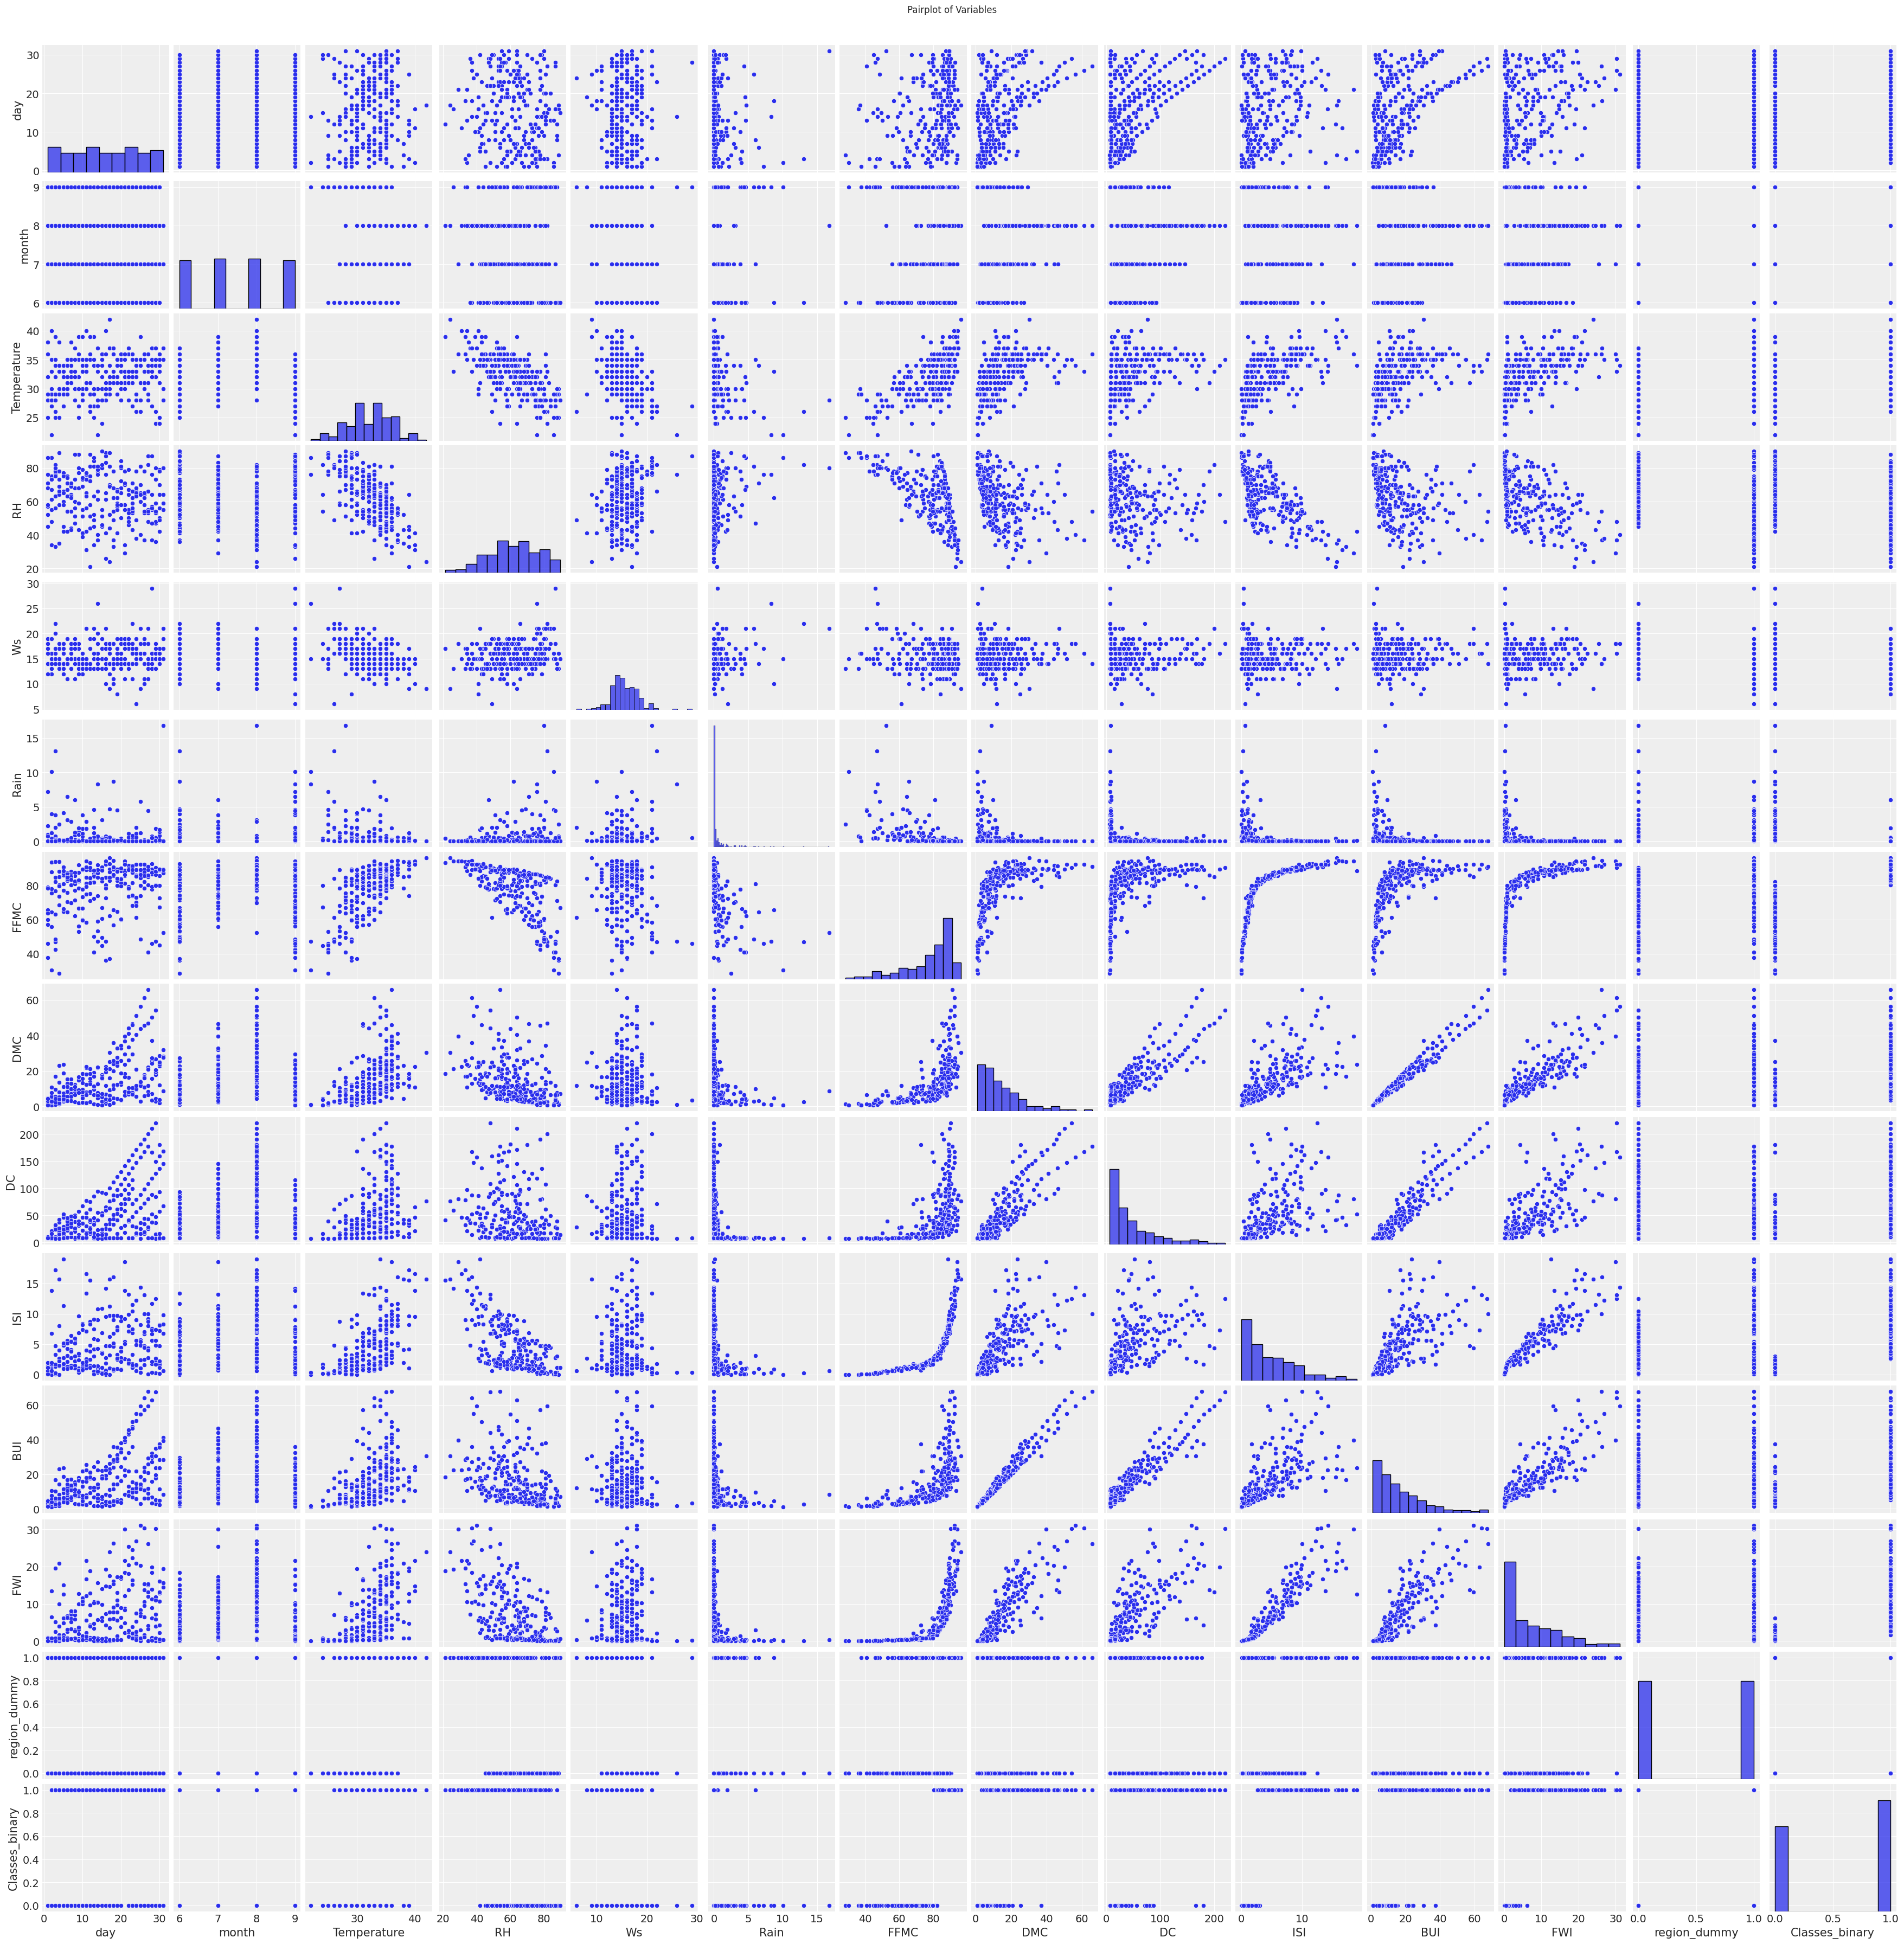

In [133]:
sns.pairplot(fires, height=2.5)
plt.suptitle('Pairplot of Variables', y=1.02)
plt.show()

## Project

Approach: We propose to use a Bayesian logistic regression with No U-Turn Sampling and will investigate:



1. Identify which weather observations have an impact on the likelihood of a fire in Algeria and their relation to the likelihood of a fire

2. Identify if the weather observations have a different impact between the two regions: Sidi Bel-abbes and Bejaia

3. Attempt to build a model that predicts Fire likelihood better than FWI

# Preprocess Data for Modeling

Create the variables that we will use for building our models.

In [134]:
num_regions = len(fires['region'].unique())
region_ids = pd.Categorical(fires["region"]).codes
region_unique = fires['region'].unique()
response_data = fires['Classes_binary'].values

In [135]:
continuous_cols = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
scaler = StandardScaler()
fires[continuous_cols] = scaler.fit_transform(fires[continuous_cols])

In [136]:
month = fires['month'].values
Temperature = fires['Temperature'].values
RH = fires['RH'].values
Ws = fires['Ws'].values
Rain = fires['Rain'].values
FFMC = fires['FFMC'].values
DMC = fires['DMC'].values
DC = fires['DC'].values
ISI = fires['ISI'].values
BUI = fires['BUI'].values
FWI = fires['FWI'].values

# Fire Weather Observations and Relation to Likelihood of Fires

Below we created a model using the fire weather observation data to determine the realtion of each measurement to the likelihood of a fire starting in Algeria.

## Pooled Model

Given we standardized the data, we selected priors for our coefficents to be normal distributions centered around 0 and variance of 10 given this is relatively large for standardized data. We chose these priors because we are generally unfamilar with which fire weather conditions have what effect on fire likelihood so we decided to priors that bring very little information to the data.

We then build the model and generate the traces.

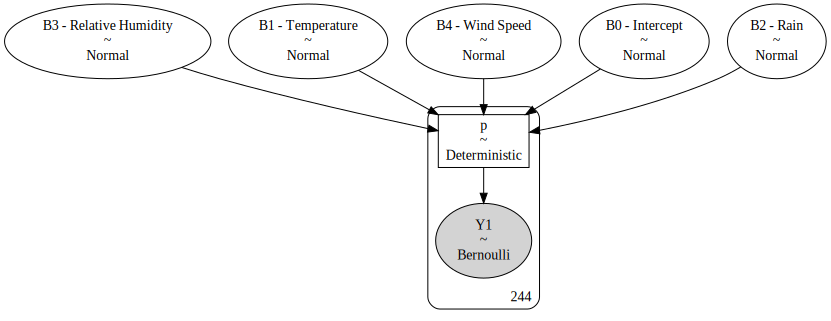

In [137]:
with pm.Model() as measurement_model:
  B0 = pm.Normal('B0 - Intercept', mu = 0, sigma = 10)
  B1 = pm.Normal('B1 - Temperature', mu = 0, sigma = 10)
  B2 = pm.Normal('B2 - Rain', mu = 0, sigma = 10)
  B3 = pm.Normal('B3 - Relative Humidity', mu = 0, sigma = 10)
  B4 = pm.Normal('B4 - Wind Speed', mu = 0, sigma = 10)

  eta = B0 + B1 * Temperature + B2 * Rain + B3 * RH + B4 * Ws
  p = pm.Deterministic('p', pm.invlogit(eta))
  Y1 = pm.Bernoulli('Y1', p = p, observed = response_data)

pm.model_to_graphviz(measurement_model)

In [138]:
graph = pm.model_to_graphviz(measurement_model)
#graph.render(filename='path/to/exported/graph2', format='png')

In [139]:
with measurement_model:
    trace = pm.sample(random_seed = random_seed, return_inferencedata=False)
    measurement_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

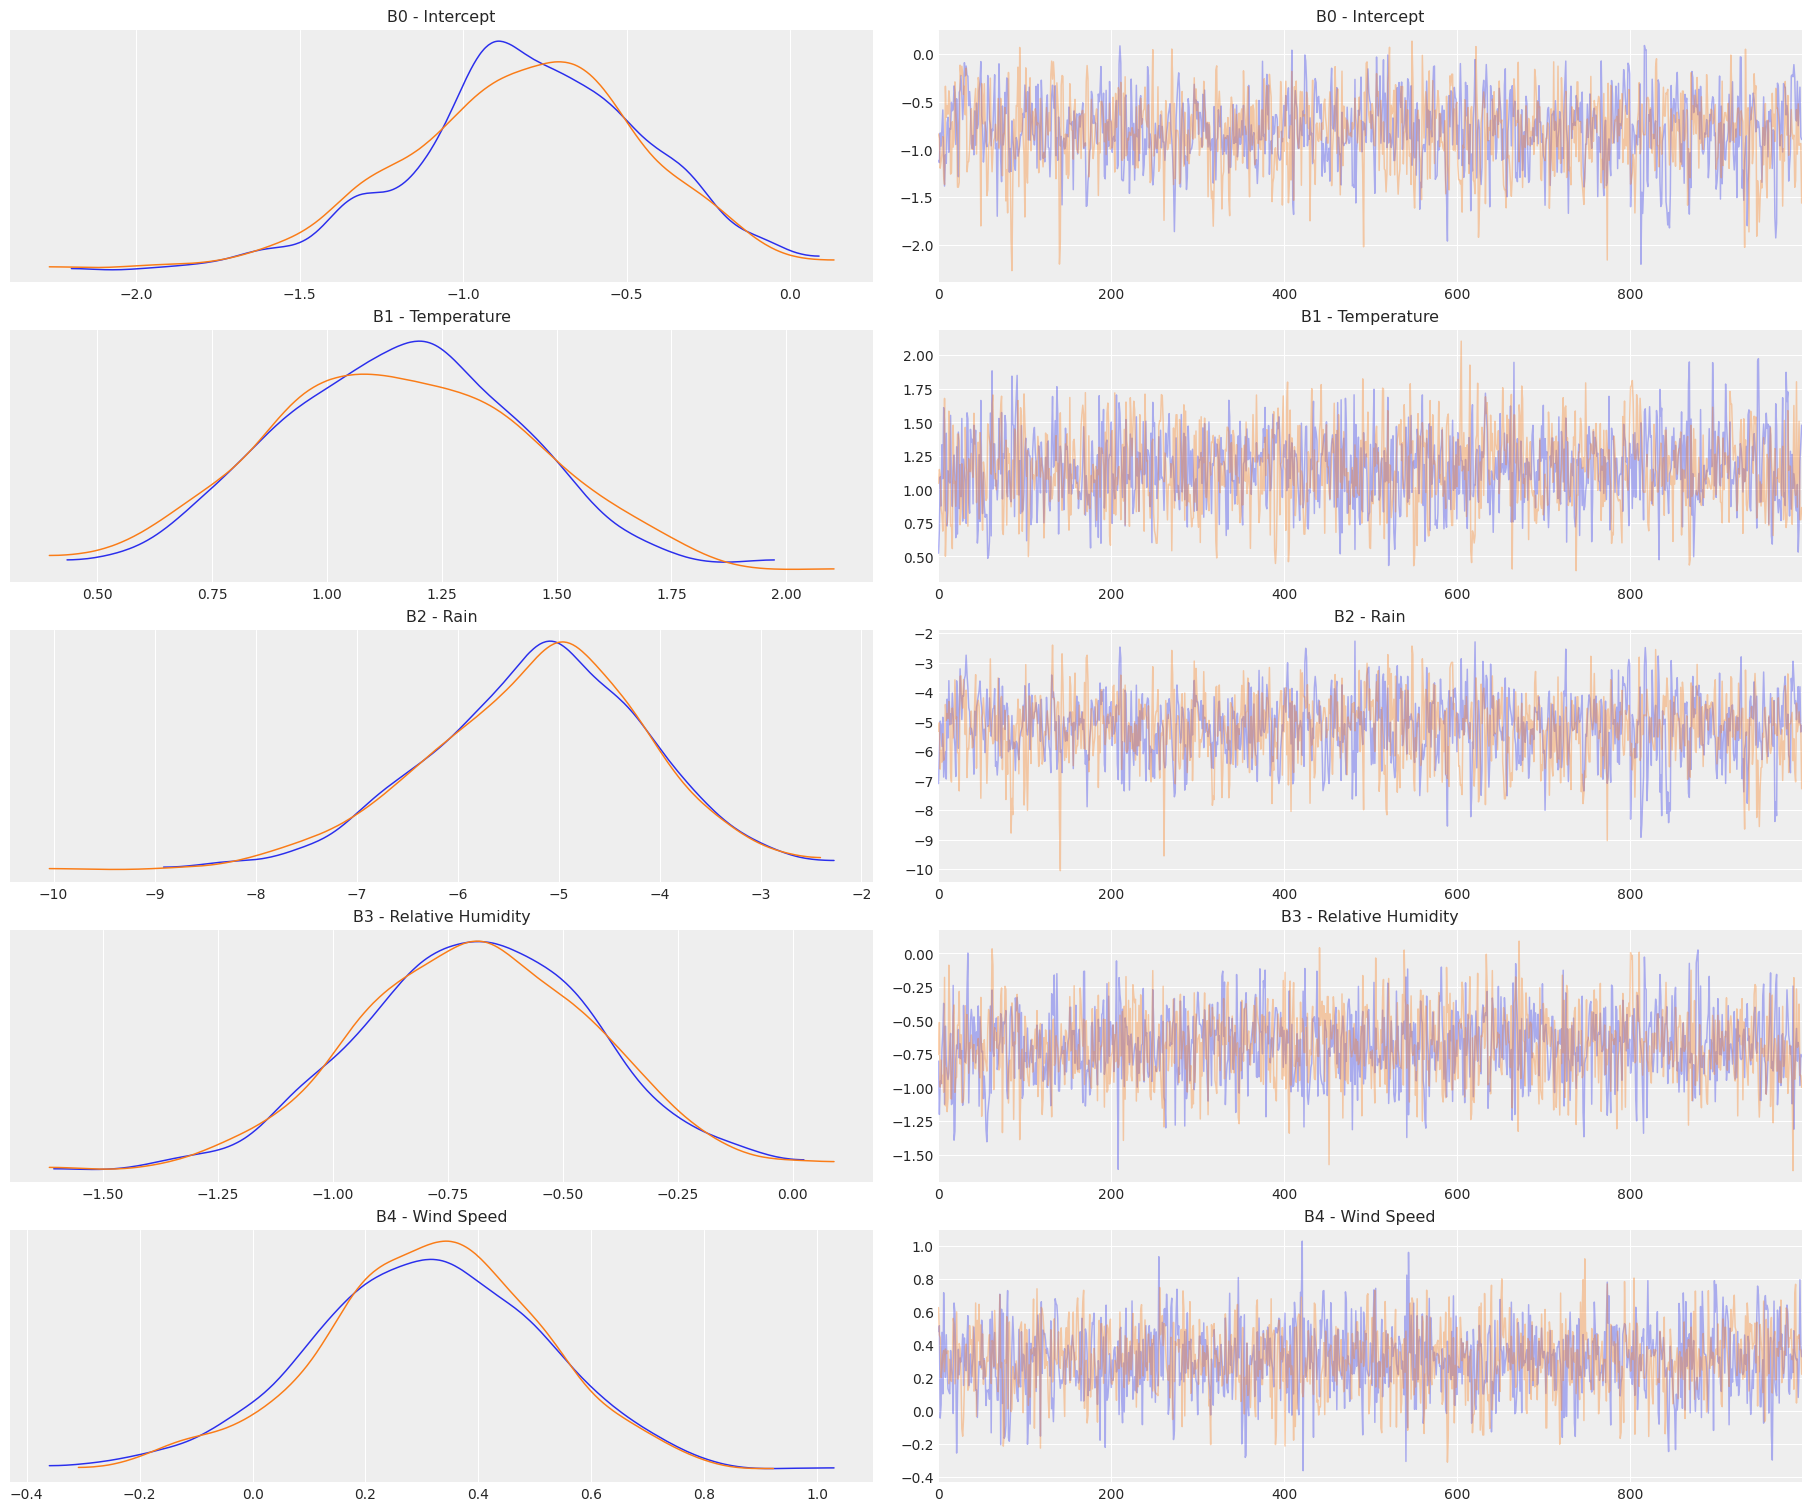

In [140]:
az.plot_trace(measurement_trace, compact = False, var_names =['B0 - Intercept'
                                                              ,'B1 - Temperature'
                                                              ,'B2 - Rain'
                                                              ,'B3 - Relative Humidity'
                                                              ,'B4 - Wind Speed']
              , figsize = (18,15));

In [141]:
az.summary(measurement_trace,  var_names =['B0 - Intercept'
                                            ,'B1 - Temperature'
                                            ,'B2 - Rain'
                                            ,'B3 - Relative Humidity'
                                            ,'B4 - Wind Speed'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
B0 - Intercept         -0.809  0.365  -1.420   -0.072      0.010    0.007   
B1 - Temperature        1.155  0.276   0.652    1.670      0.007    0.005   
B2 - Rain              -5.213  1.100  -7.403   -3.239      0.031    0.022   
B3 - Relative Humidity -0.688  0.256  -1.153   -0.204      0.006    0.004   
B4 - Wind Speed         0.311  0.202  -0.041    0.734      0.005    0.004   

                        ess_bulk  ess_tail  r_hat  
B0 - Intercept            1291.0    1108.0    1.0  
B1 - Temperature          1511.0    1154.0    1.0  
B2 - Rain                 1321.0    1138.0    1.0  
B3 - Relative Humidity    1946.0    1509.0    1.0  
B4 - Wind Speed           1921.0    1288.0    1.0

The R_hat values are 1.0 so the model converged and trace plots look good.

<Axes: title={'center': 'Y1 / Y1'}>

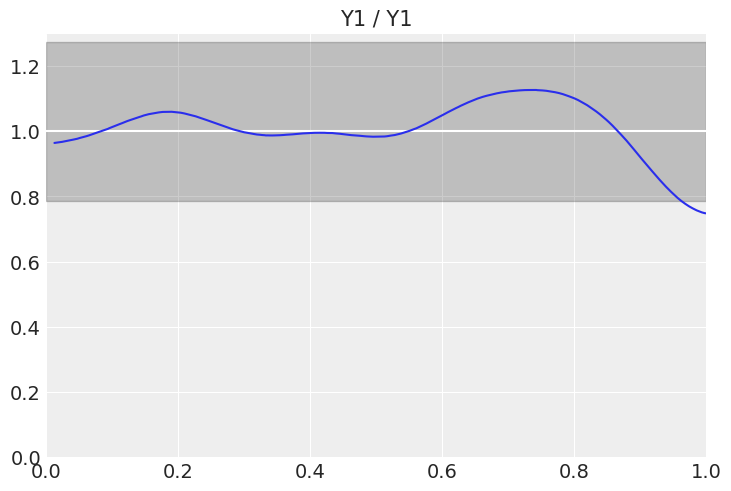

In [142]:
measurement_pp = pm.sample_posterior_predictive(measurement_trace,
                                           model = measurement_model,
                                           random_seed = random_seed)
az.plot_bpv(measurement_pp)

<Axes: xlabel='Y1 / Y1'>

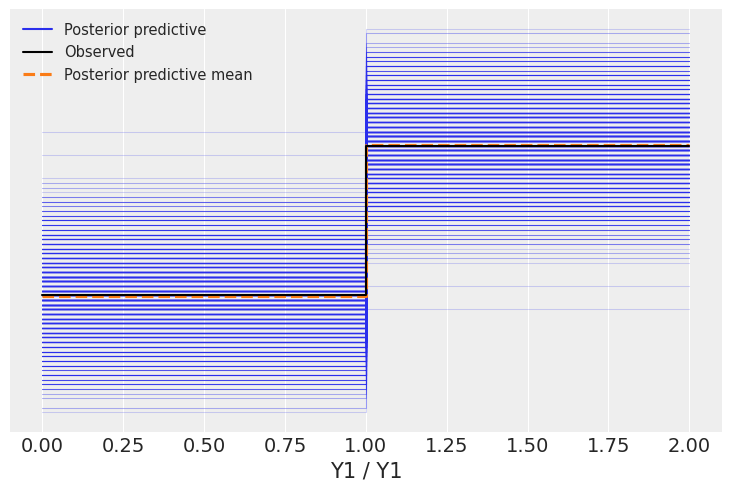

In [143]:
az.plot_ppc(measurement_pp)

The postieror predictive checks look good. Our ppc has high variance likely because of the smaler dataset, but the posterior precitive mean looks relatively similar to the observed.

array([[<Axes: title={'center': 'B0 - Intercept'}>,
        <Axes: title={'center': 'B1 - Temperature'}>,
        <Axes: title={'center': 'B2 - Rain'}>],
       [<Axes: title={'center': 'B3 - Relative Humidity'}>,
        <Axes: title={'center': 'B4 - Wind Speed'}>, <Axes: >]],
      dtype=object)

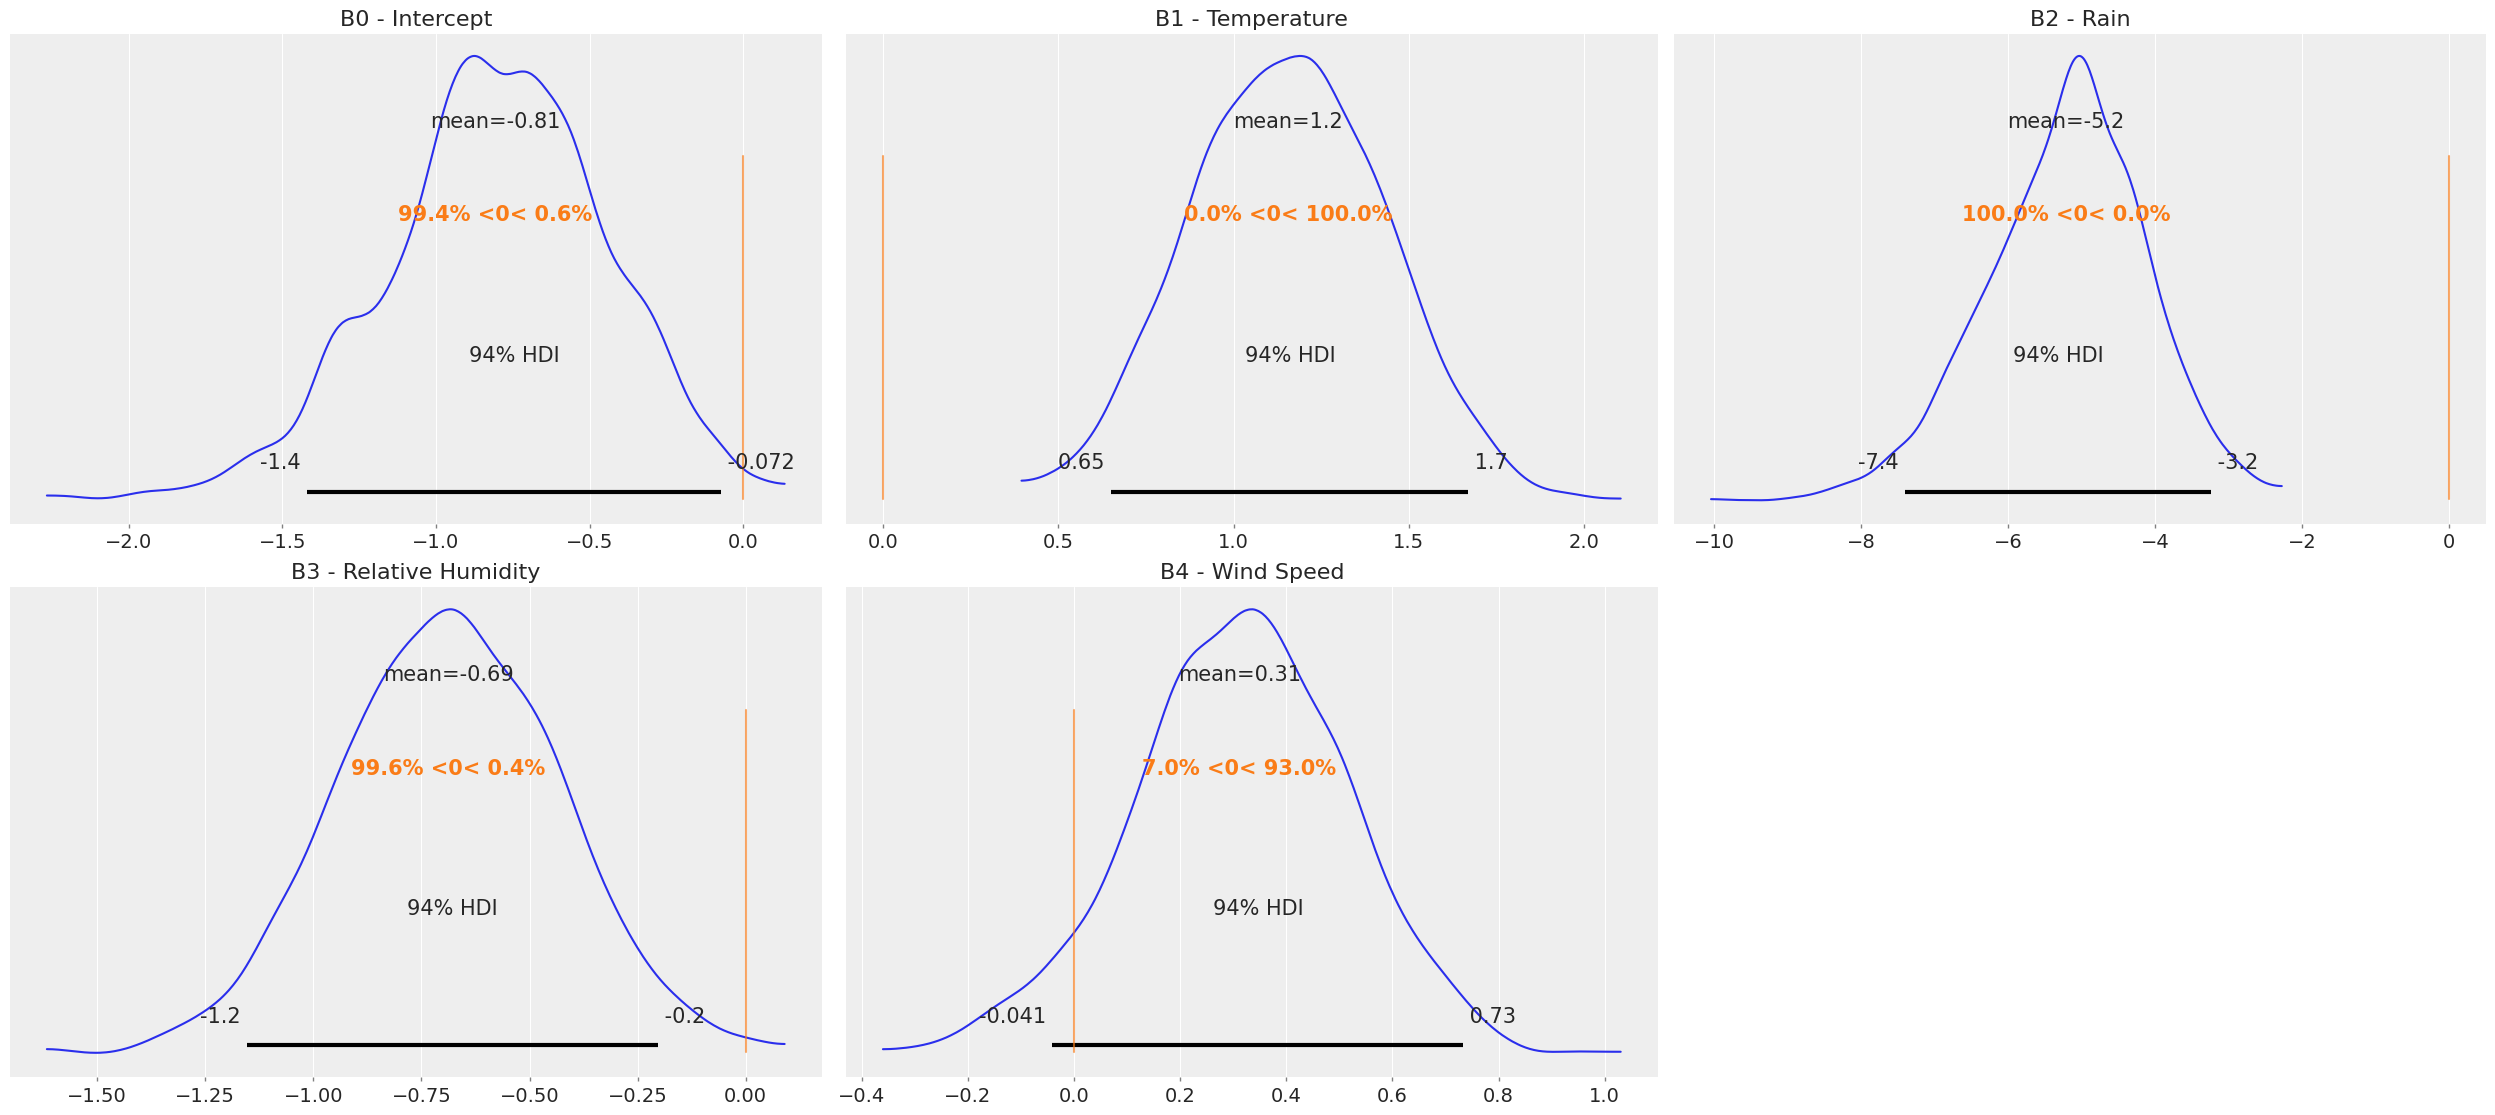

In [144]:
az.plot_posterior(measurement_trace
                  , var_names =['B0 - Intercept'
                                ,'B1 - Temperature'
                                ,'B2 - Rain'
                                ,'B3 - Relative Humidity'
                                ,'B4 - Wind Speed']
                  , ref_val = 0,)

# Differences in Weather Observations between Bejaia and Sidi-Bel Abbes

## Unpooled

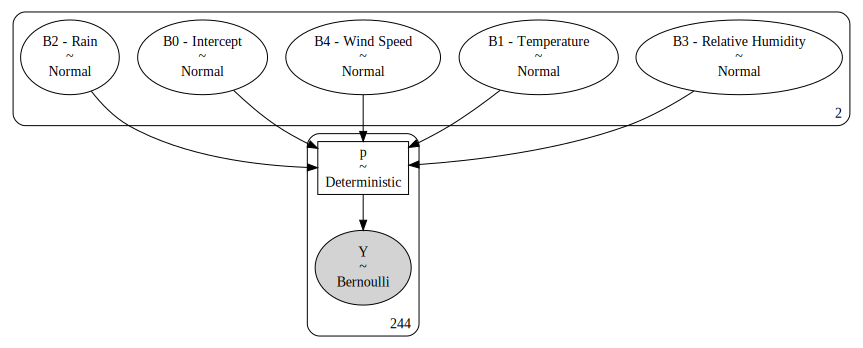

In [145]:
with pm.Model() as unpooled_measurement_model:
    B0 = pm.Normal('B0 - Intercept', mu = 0, sigma = 10, shape=num_regions)
    B1 = pm.Normal('B1 - Temperature', mu = 0, sigma = 10, shape=num_regions)
    B2 = pm.Normal('B2 - Rain', mu = 0, sigma = 10, shape=num_regions)
    B3 = pm.Normal('B3 - Relative Humidity', mu = 0, sigma = 10, shape=num_regions)
    B4 = pm.Normal('B4 - Wind Speed', mu = 0, sigma = 10, shape=num_regions)

    eta = B0[region_ids] + B1[region_ids] * Temperature + B2[region_ids] * Rain + B3[region_ids] * RH + B4[region_ids] * Ws
    p = pm.Deterministic('p', pm.invlogit(eta))

    Y = pm.Bernoulli('Y', p=p, observed = response_data)

pm.model_to_graphviz(unpooled_measurement_model)

In [146]:
graph = pm.model_to_graphviz(unpooled_measurement_model)
#graph.render(filename='path/to/exported/graph3', format='png')

In [147]:
with unpooled_measurement_model:
    trace = pm.sample(random_seed = random_seed, return_inferencedata=False)
    unpooled_measurement_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

In [148]:
az.summary(unpooled_measurement_trace,  var_names =['B0 - Intercept'
                                                      ,'B1 - Temperature'
                                                      ,'B2 - Rain'
                                                      ,'B3 - Relative Humidity'
                                                      ,'B4 - Wind Speed'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
B0 - Intercept[0]          -7.124  1.700 -10.360   -4.074      0.047    0.034   
B0 - Intercept[1]           0.088  0.345  -0.568    0.724      0.009    0.008   
B1 - Temperature[0]         1.370  0.536   0.459    2.424      0.014    0.010   
B1 - Temperature[1]         1.298  0.384   0.592    2.031      0.009    0.007   
B2 - Rain[0]              -23.153  4.849 -32.040  -14.273      0.134    0.096   
B2 - Rain[1]               -3.105  0.859  -4.668   -1.585      0.023    0.016   
B3 - Relative Humidity[0]  -0.412  0.545  -1.443    0.632      0.014    0.011   
B3 - Relative Humidity[1]  -0.794  0.342  -1.512   -0.234      0.008    0.006   
B4 - Wind Speed[0]          0.237  0.343  -0.377    0.921      0.008    0.007   
B4 - Wind Speed[1]          0.575  0.310   0.042    1.177      0.007    0.005   

                           ess_bulk  ess_tail  r_hat  
B0 - Intercept[0]            1332.0    1251.0    1.0  
B0 - Intercept[1]            1488.0    1248.0    1.0  
B1 - Temperature[0]          1553.0    1416.0    1.0  
B1 - Temperature[1]          1735.0    1456.0    1.0  
B2 - Rain[0]                 1315.0    1132.0    1.0  
B2 - Rain[1]                 1501.0    1279.0    1.0  
B3 - Relative Humidity[0]    1512.0    1266.0    1.0  
B3 - Relative Humidity[1]    1978.0    1378.0    1.0  
B4 - Wind Speed[0]           1666.0    1316.0    1.0  
B4 - Wind Speed[1]           1923.0    1495.0    1.0

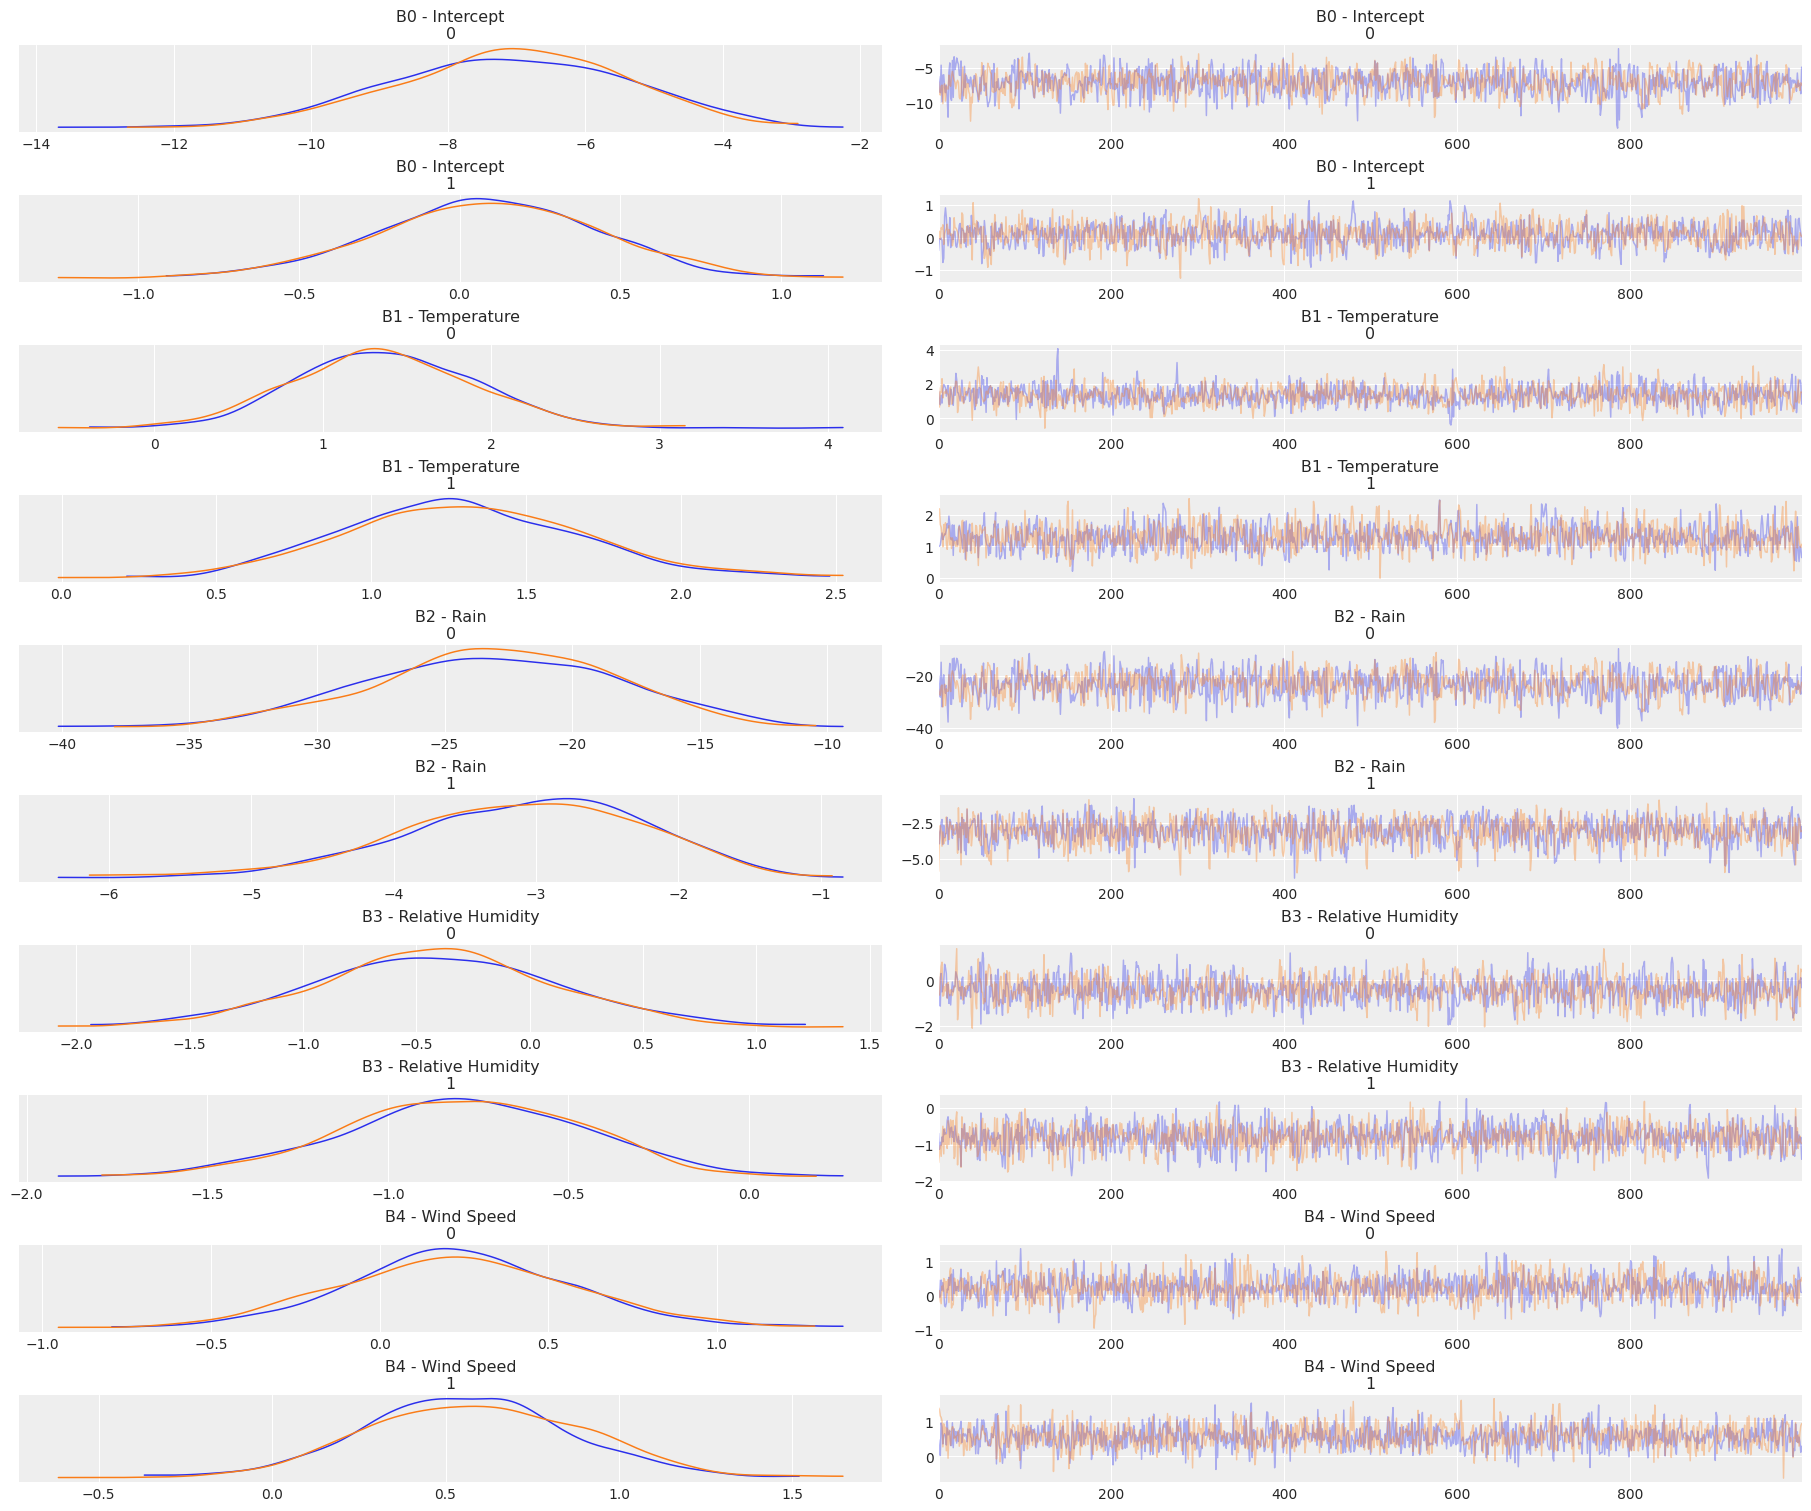

In [149]:
az.plot_trace(unpooled_measurement_trace, compact = False, var_names =['B0 - Intercept'
                                                                      ,'B1 - Temperature'
                                                                      ,'B2 - Rain'
                                                                      ,'B3 - Relative Humidity'
                                                                      ,'B4 - Wind Speed'], figsize = (18,15));

<Axes: title={'center': 'Y / Y'}>

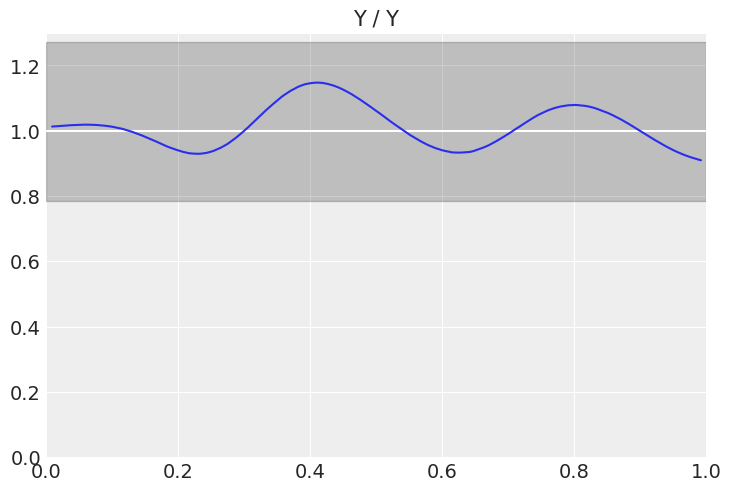

In [150]:
unpooled_measurement_pp = pm.sample_posterior_predictive(unpooled_measurement_trace,
                                           model = unpooled_measurement_model,
                                           random_seed = random_seed)
az.plot_bpv(unpooled_measurement_pp)

<Axes: xlabel='Y / Y'>

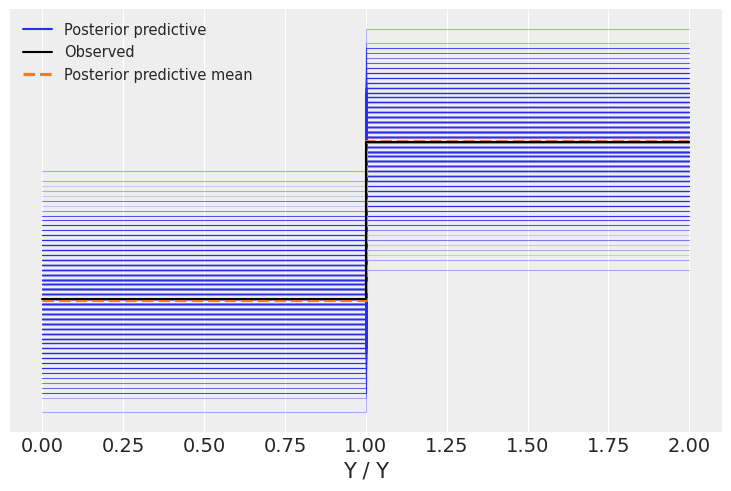

In [151]:
az.plot_ppc(unpooled_measurement_pp)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

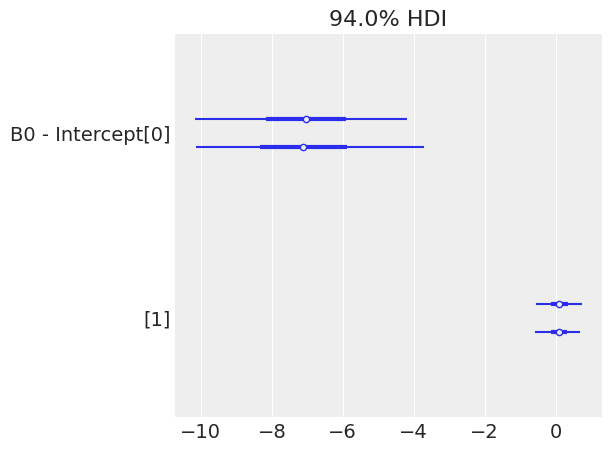

In [152]:
az.plot_forest(unpooled_measurement_trace, var_names =['B0 - Intercept'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

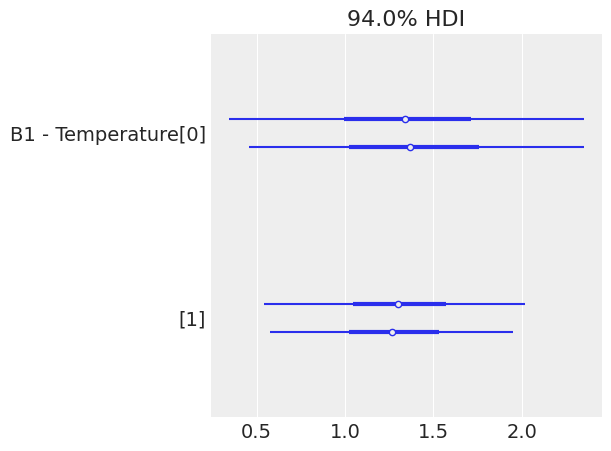

In [153]:
az.plot_forest(unpooled_measurement_trace, var_names =['B1 - Temperature'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

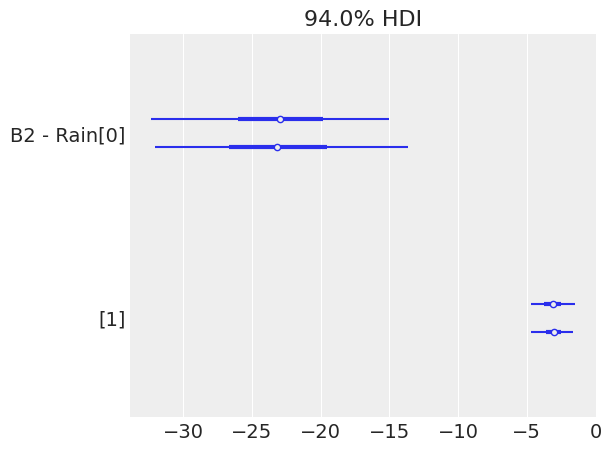

In [154]:
az.plot_forest(unpooled_measurement_trace, var_names =['B2 - Rain'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

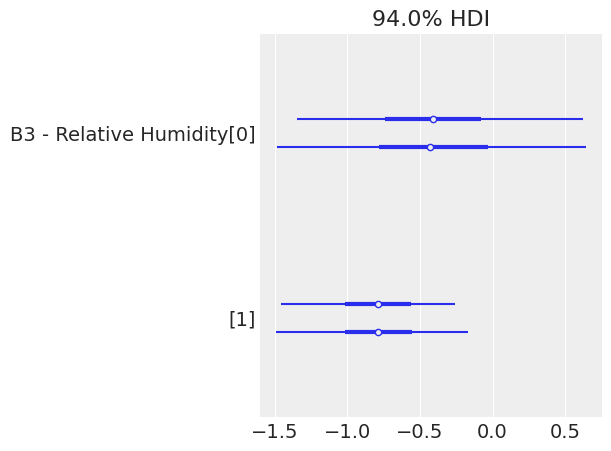

In [155]:
az.plot_forest(unpooled_measurement_trace, var_names =['B3 - Relative Humidity'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

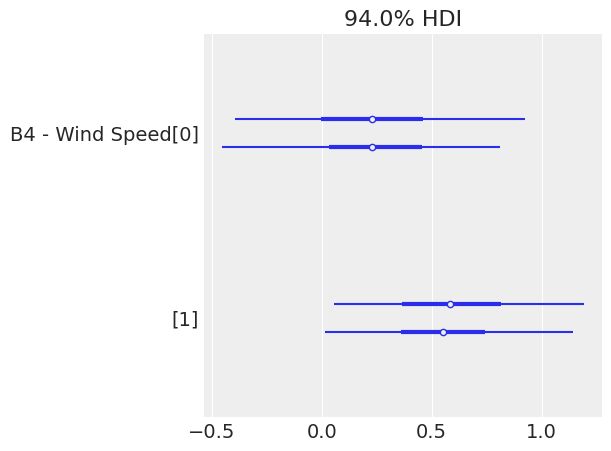

In [156]:
az.plot_forest(unpooled_measurement_trace, var_names =['B4 - Wind Speed'],)

## Hierarchical

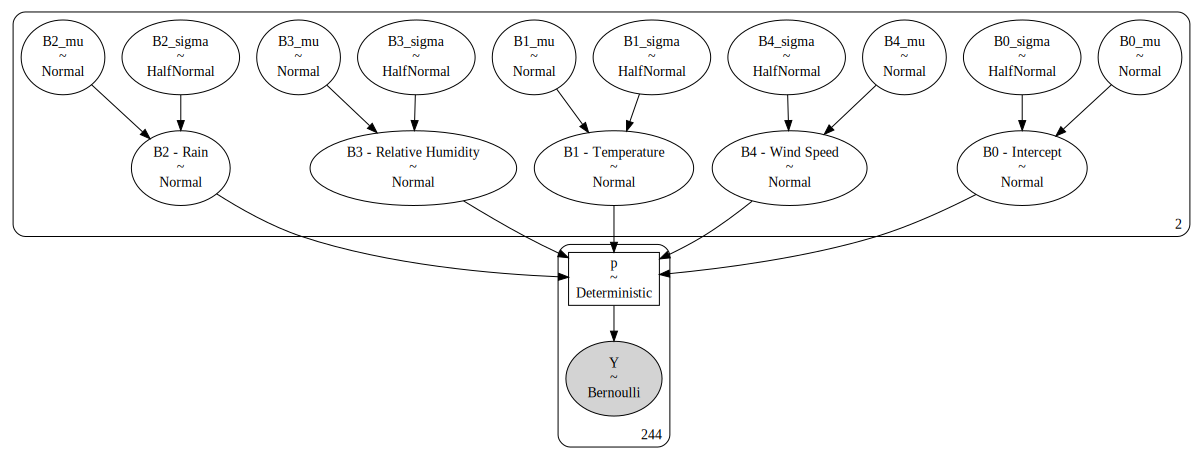

In [157]:
with pm.Model() as hierarchical_measurement_model:
    B0_mu = pm.Normal('B0_mu', mu=0, sigma=2, shape=num_regions)
    B0_sigma = pm.HalfNormal('B0_sigma', sigma=10, shape=num_regions)
    B0 = pm.Normal('B0 - Intercept', mu = B0_mu, sigma = B0_sigma, shape= num_regions)

    B1_mu = pm.Normal('B1_mu', mu=0, sigma=2, shape=num_regions)
    B1_sigma = pm.HalfNormal('B1_sigma', sigma=10, shape=num_regions)
    B1 = pm.Normal('B1 - Temperature', mu = B1_mu, sigma = B1_sigma, shape= num_regions)

    B2_mu = pm.Normal('B2_mu', mu=0, sigma=2, shape=num_regions)
    B2_sigma = pm.HalfNormal('B2_sigma', sigma=10, shape=num_regions)
    B2 = pm.Normal('B2 - Rain', mu = B2_mu, sigma = B2_sigma, shape=num_regions)

    B3_mu = pm.Normal('B3_mu', mu=0, sigma=2, shape=num_regions)
    B3_sigma = pm.HalfNormal('B3_sigma', sigma=10, shape=num_regions)
    B3 = pm.Normal('B3 - Relative Humidity', mu = B3_mu, sigma = B3_sigma, shape=num_regions)

    B4_mu = pm.Normal('B4_mu', mu=0, sigma=2, shape=num_regions)
    B4_sigma = pm.HalfNormal('B4_sigma', sigma=10, shape=num_regions)
    B4 = pm.Normal('B4 - Wind Speed', mu = B4_mu, sigma = B4_sigma, shape=num_regions)

    eta = B0[region_ids] + B1[region_ids] * Temperature + B2[region_ids] * Rain + B3[region_ids] * RH + B4[region_ids] * Ws
    p = pm.Deterministic('p', pm.invlogit(eta))

    Y = pm.Bernoulli('Y', p=p, observed = response_data)

pm.model_to_graphviz(hierarchical_measurement_model)

In [158]:
graph = pm.model_to_graphviz(hierarchical_measurement_model)
#graph.render(filename='path/to/exported/graph', format='png')

In [159]:
with hierarchical_measurement_model:
    trace = pm.sample(random_seed = random_seed, return_inferencedata=False)
    hierarchical_measurement_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

In [160]:
az.summary(hierarchical_measurement_trace,  var_names =['B0 - Intercept'
                                                              ,'B1 - Temperature'
                                                              ,'B2 - Rain'
                                                              ,'B3 - Relative Humidity'
                                                              ,'B4 - Wind Speed'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
B0 - Intercept[0]          -8.300  2.209 -12.552   -4.417      0.079    0.057   
B0 - Intercept[1]           0.113  0.337  -0.506    0.748      0.010    0.007   
B1 - Temperature[0]         1.429  0.537   0.489    2.495      0.016    0.012   
B1 - Temperature[1]         1.300  0.370   0.624    1.978      0.010    0.007   
B2 - Rain[0]              -26.601  6.342 -38.406  -14.915      0.226    0.162   
B2 - Rain[1]               -2.965  0.852  -4.442   -1.316      0.026    0.019   
B3 - Relative Humidity[0]  -0.467  0.550  -1.546    0.523      0.017    0.012   
B3 - Relative Humidity[1]  -0.788  0.326  -1.390   -0.179      0.008    0.006   
B4 - Wind Speed[0]          0.259  0.370  -0.412    1.011      0.009    0.007   
B4 - Wind Speed[1]          0.586  0.308   0.061    1.209      0.007    0.005   

                           ess_bulk  ess_tail  r_hat  
B0 - Intercept[0]             814.0     815.0    1.0  
B0 - Intercept[1]            1263.0    1062.0    1.0  
B1 - Temperature[0]          1100.0    1012.0    1.0  
B1 - Temperature[1]          1469.0    1176.0    1.0  
B2 - Rain[0]                  810.0     933.0    1.0  
B2 - Rain[1]                 1108.0    1174.0    1.0  
B3 - Relative Humidity[0]    1076.0    1295.0    1.0  
B3 - Relative Humidity[1]    1671.0    1243.0    1.0  
B4 - Wind Speed[0]           1549.0    1434.0    1.0  
B4 - Wind Speed[1]           1798.0    1342.0    1.0

In [161]:
az.summary(hierarchical_measurement_trace)['r_hat'].max()

1.01

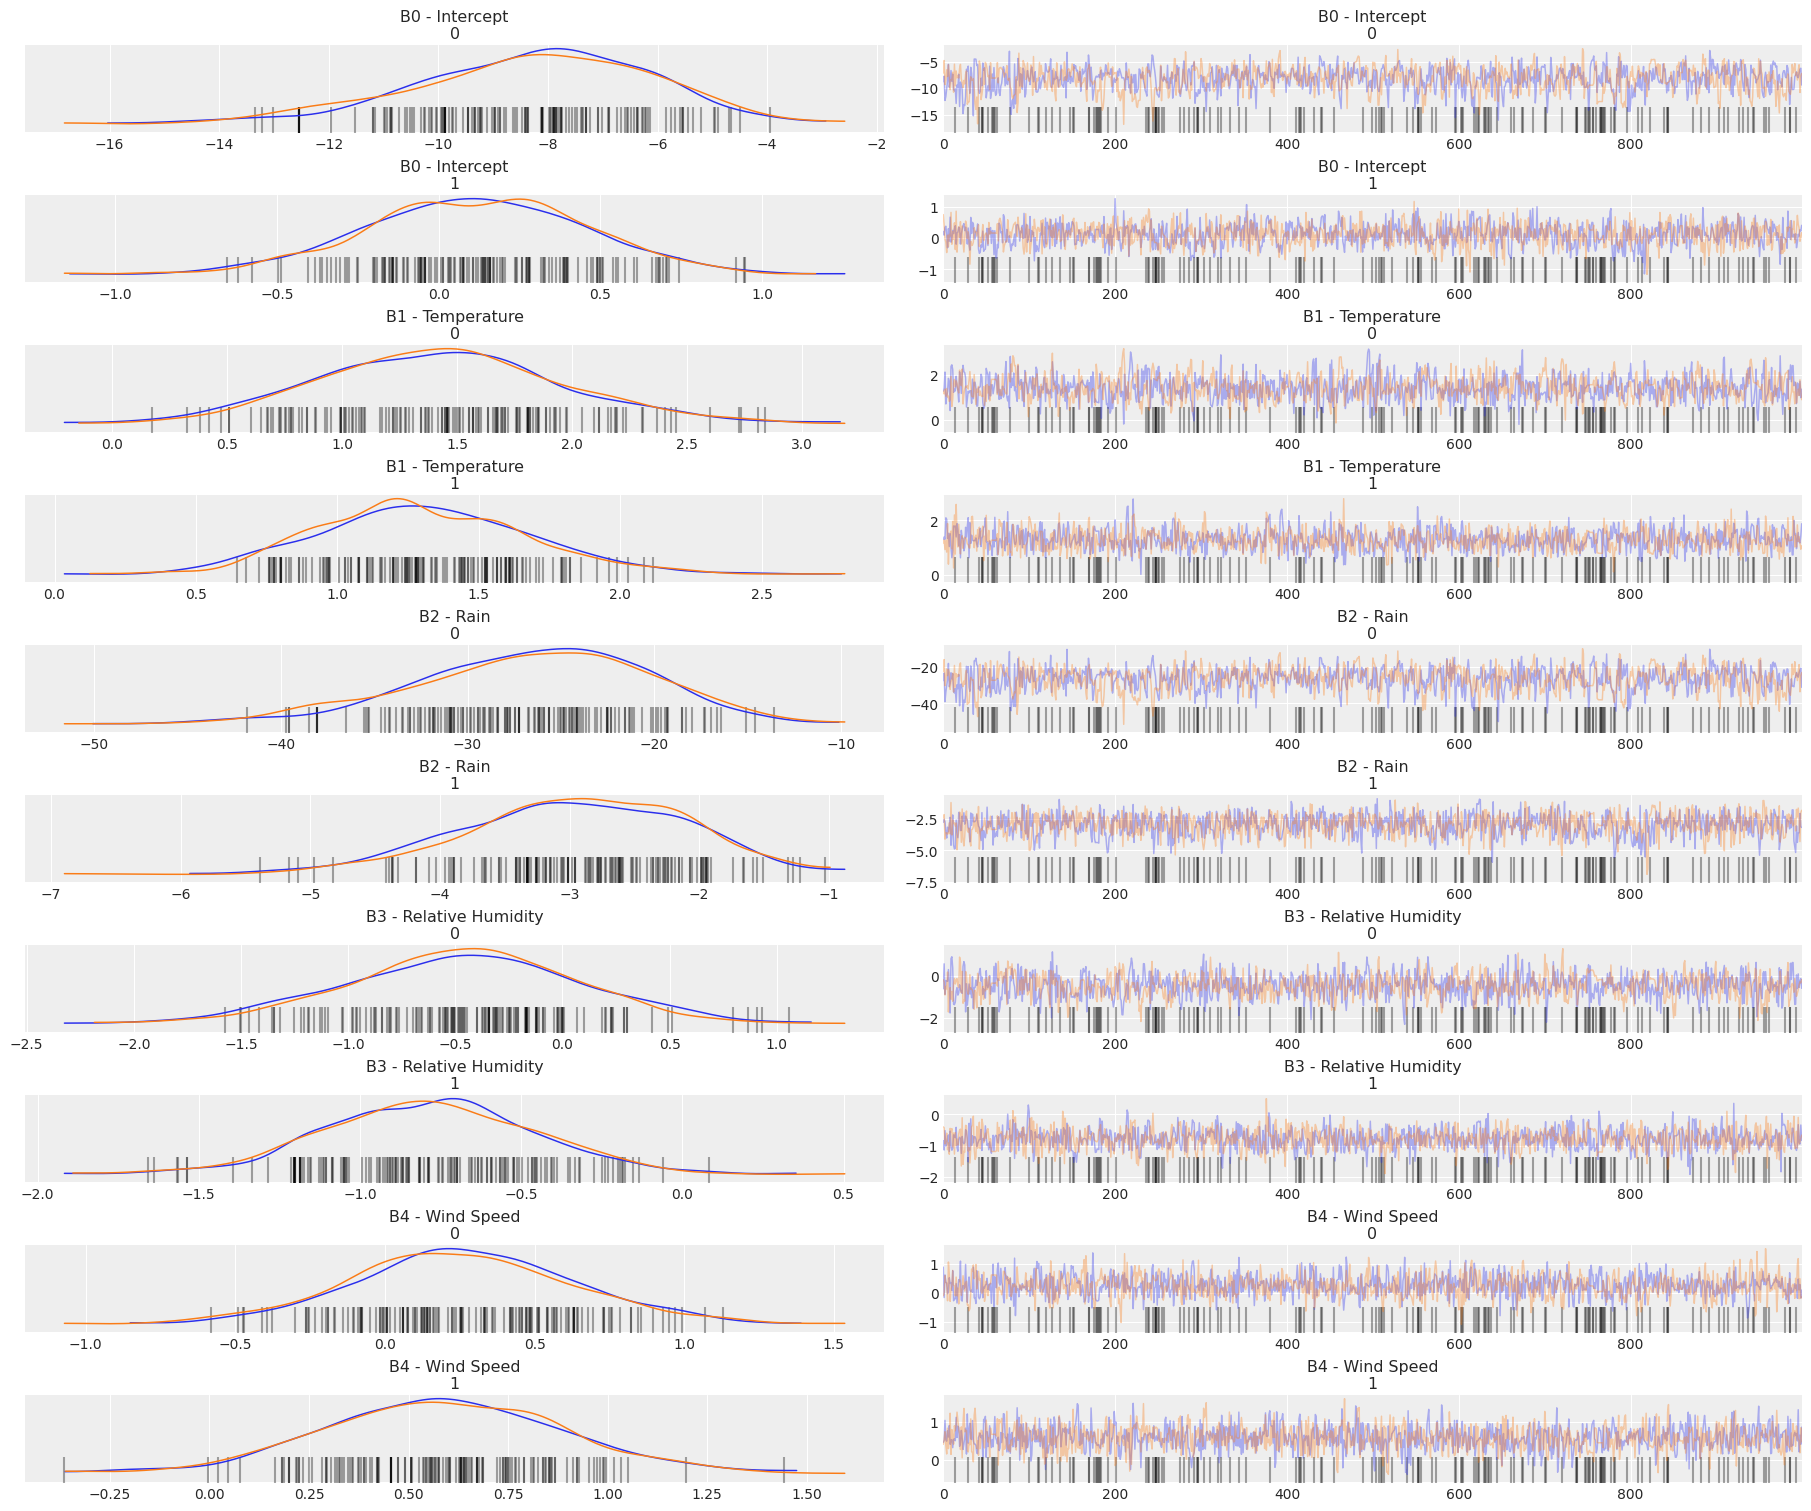

In [162]:
az.plot_trace(hierarchical_measurement_trace, compact = False
              , var_names =['B0 - Intercept'
                            ,'B1 - Temperature'
                            ,'B2 - Rain'
                            ,'B3 - Relative Humidity'
                            ,'B4 - Wind Speed']
              , figsize = (18,15));

<Axes: title={'center': 'Y / Y'}>

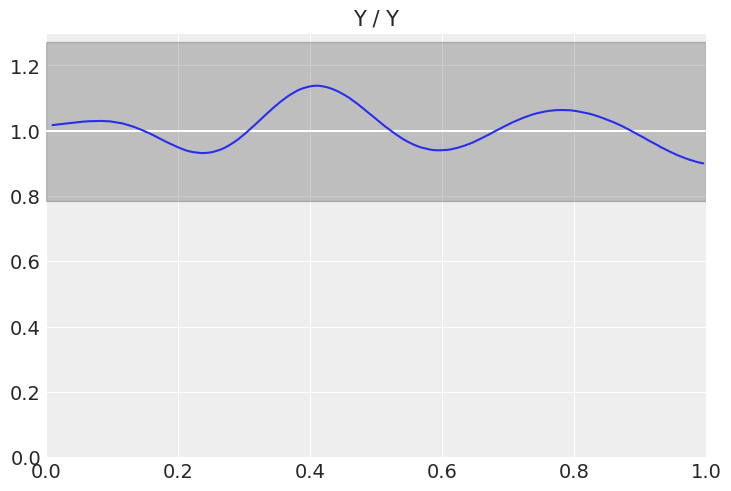

In [163]:
hierarchical_measurement_pp = pm.sample_posterior_predictive(hierarchical_measurement_trace,
                                           model = hierarchical_measurement_model,
                                           random_seed = random_seed)
az.plot_bpv(hierarchical_measurement_pp)

<Axes: xlabel='Y / Y'>

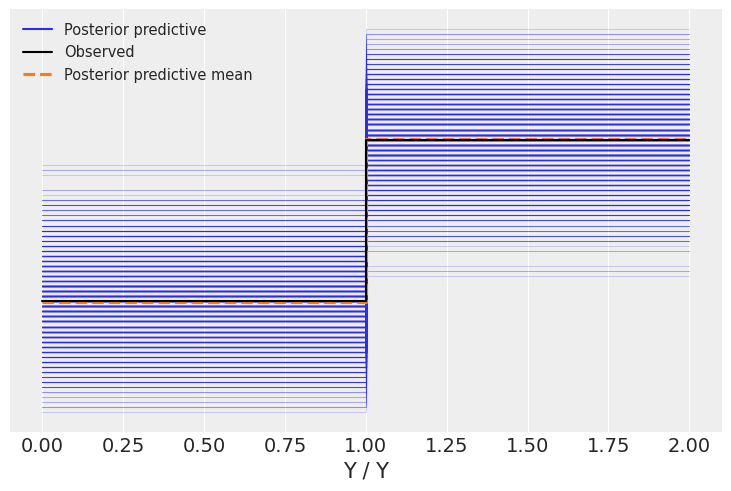

In [164]:
az.plot_ppc(hierarchical_measurement_pp)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

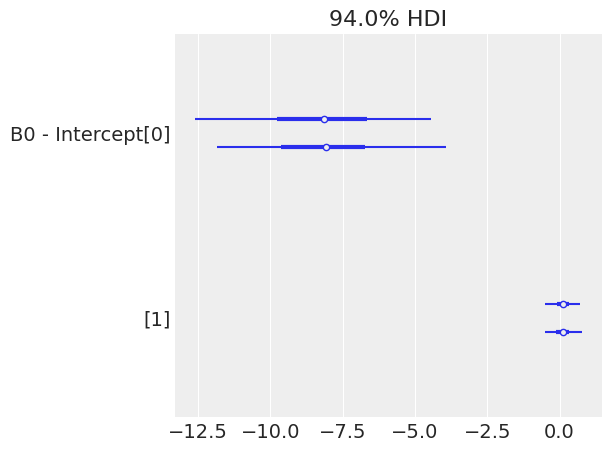

In [165]:
az.plot_forest(hierarchical_measurement_trace, var_names =['B0 - Intercept'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

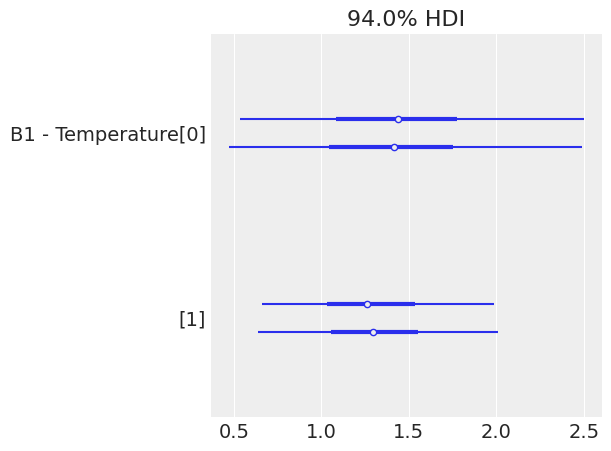

In [166]:
az.plot_forest(hierarchical_measurement_trace, var_names =['B1 - Temperature'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

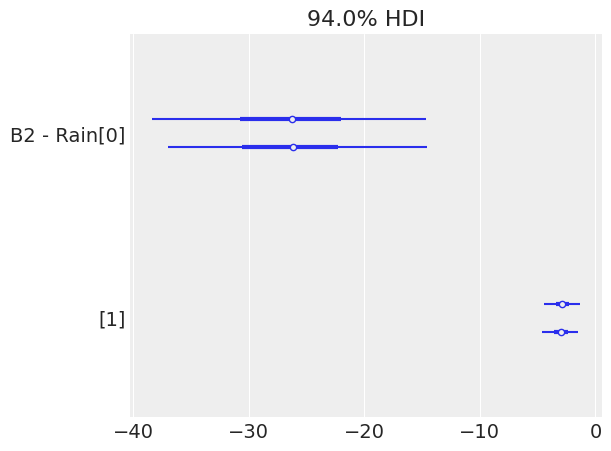

In [167]:
az.plot_forest(hierarchical_measurement_trace, var_names =['B2 - Rain'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

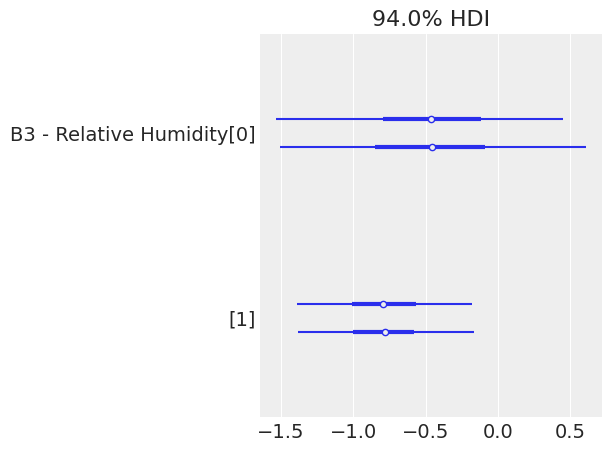

In [168]:
az.plot_forest(hierarchical_measurement_trace, var_names =['B3 - Relative Humidity'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

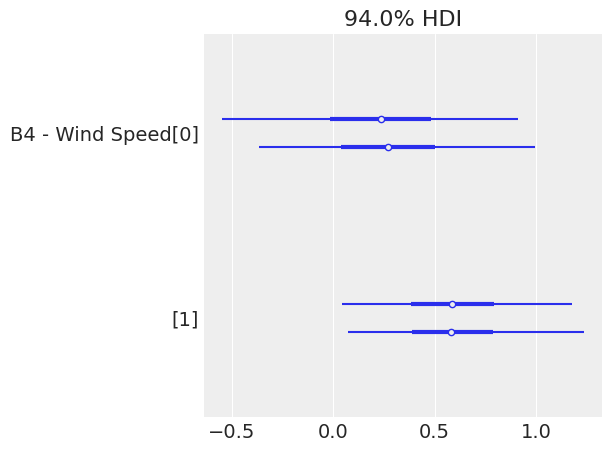

In [169]:
az.plot_forest(hierarchical_measurement_trace, var_names =['B4 - Wind Speed'],)

## Findings

In [170]:
az.compare({'pooled':measurement_trace
            , 'unpooled':unpooled_measurement_trace}
            , ic='waic')

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank   elpd_waic     p_waic  elpd_diff   weight         se  \
unpooled     0  -91.810369  15.318931   0.000000  0.88245  12.436793   
pooled       1 -108.325341  14.438076  16.514971  0.11755  19.975971   

                dse  warning scale  
unpooled   0.000000     True   log  
pooled    10.489759     True   log

In [171]:
az.compare({'hierarchical':hierarchical_measurement_trace
            , 'pooled':measurement_trace}
            , ic='waic')

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank   elpd_waic     p_waic  elpd_diff    weight         se  \
hierarchical     0  -91.608953  15.667678   0.000000  0.816435  12.248835   
pooled           1 -108.325341  14.438076  16.716388  0.183565  19.975971   

                    dse  warning scale  
hierarchical   0.000000     True   log  
pooled        11.185732     True   log

We see that both the hierarchical and unpooled models are preferred over the pooled model, as they capture the differences in the estimates between the groups.

In [172]:
az.compare({'hierarchical':hierarchical_measurement_trace
            , 'unpooled':unpooled_measurement_trace}
            , ic='waic')

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank  elpd_waic     p_waic  elpd_diff    weight         se  \
hierarchical     0 -91.608953  15.667678   0.000000  0.773471  12.248835   
unpooled         1 -91.810369  15.318931   0.201417  0.226529  12.436793   

                   dse  warning scale  
hierarchical  0.000000     True   log  
unpooled      0.862265     True   log

However, comparing the hierarchical and unpooled models, we see that hierarchical performs much stronger from the strength of using hierarchical priors and shrinking parameters.

The hierarchical model outperforms the pooled and unpooled model so we discuss the findings from this model with regards to the predictor coefficients.

The intercept was significant (non-zero) for the Bejaia region with a negative coefficient, indicating that there is less likelihood of forest fires compared to Sidi-Bel Abbes region holding all other variables constant.  

For both regions, temperature was a significant predictor with a very similar positive coefficient estimate, indicating that as temperature increases, the likelihood of forest fires increases, as expected.

For both regions, rain was a significant predictor with varying negative estimates. In the Bejaia region, rain decreases the odds of a forest fire occurring much more compared to the Sidi-Bel Abbes region.

For Sidi-Bel Abbes, humidity and wind speed both prove to be significant, where a decrease in humidity increases the odds of a forest fire and an increase in wind speed increases the odds of a forest fire, while these predictors were insignificant to the Bejaia region.

Given our model and findings, we suggest that it would be most beneficial to model the likelihood of fires using a hierarchical model to account for the difference in parameter estimates. Bejaia has a lower baseline for odds of forest fires compared to Sidi-Bel Abbes, while Sidi-Bel Abbes is more sensitive to humidity and wind speed. In addition, temperature and rain was a significant predictor for both regions, although rain had a much stronger impact for Bejaia.

# Is FWI best way to Predict Fires in Algeria?

## FWI Pooled

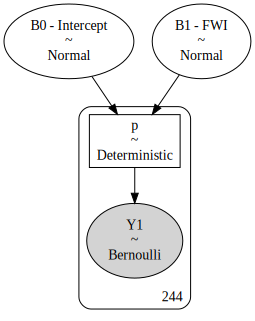

In [173]:
with pm.Model() as FWI_model:
  B0 = pm.Normal('B0 - Intercept', mu = 0, sigma = 10)
  B1 = pm.Normal('B1 - FWI', mu = 0, sigma = 10)

  eta = B0 + B1 * FWI
  p = pm.Deterministic('p', pm.invlogit(eta))
  Y1 = pm.Bernoulli('Y1', p = p, observed = response_data)

pm.model_to_graphviz(FWI_model)

In [174]:
graph = pm.model_to_graphviz(FWI_model)
#graph.render(filename='path/to/exported/graph4', format='png')

In [175]:
with FWI_model:
    trace = pm.sample(random_seed = random_seed, return_inferencedata=False)
    FWI_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

In [176]:
az.summary(FWI_trace,  var_names =['B0 - Intercept','B1 - FWI'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B0 - Intercept   5.485  1.053   3.577    7.552      0.059    0.042     323.0   
B1 - FWI        10.896  1.806   7.710   14.353      0.101    0.071     331.0   

                ess_tail  r_hat  
B0 - Intercept     355.0   1.01  
B1 - FWI           395.0   1.01

In [177]:
az.summary(FWI_trace)['r_hat'].max()

1.01

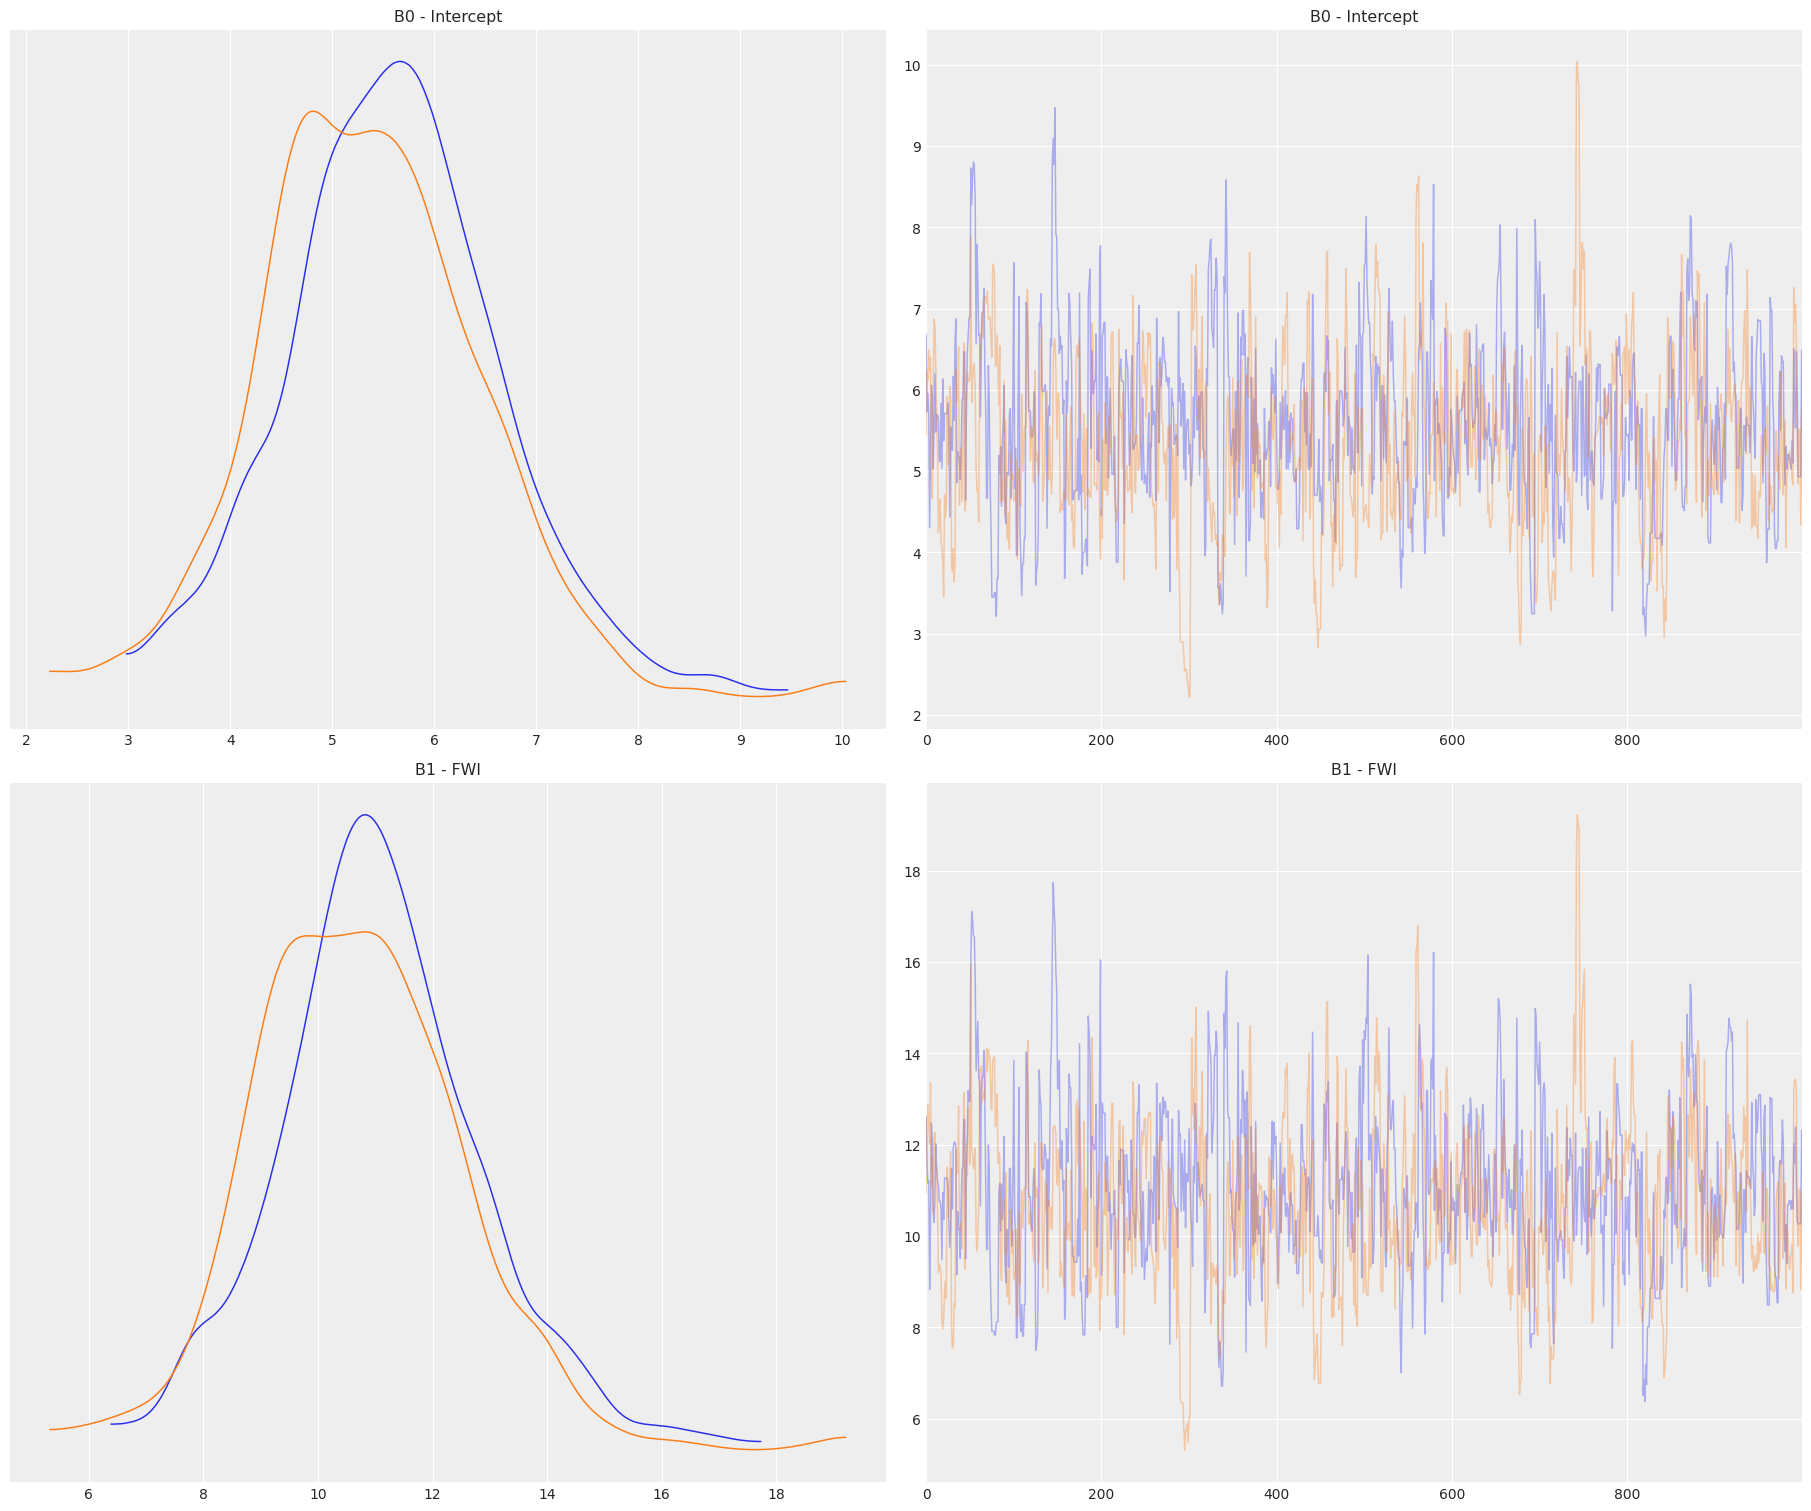

In [178]:
az.plot_trace(FWI_trace, compact = False, var_names =['B0 - Intercept','B1 - FWI'], figsize = (18,15));

<Axes: title={'center': 'Y1 / Y1'}>

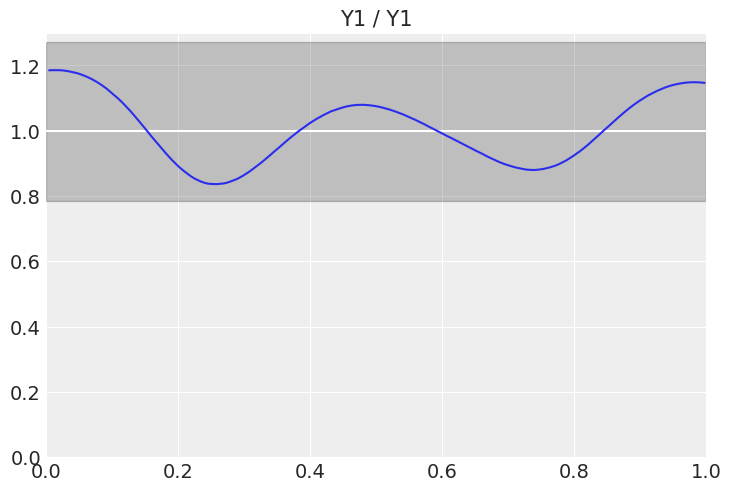

In [179]:
FWI_pp = pm.sample_posterior_predictive(FWI_trace,
                                           model = FWI_model,
                                           random_seed = random_seed)
az.plot_bpv(FWI_pp)

<Axes: xlabel='Y1 / Y1'>

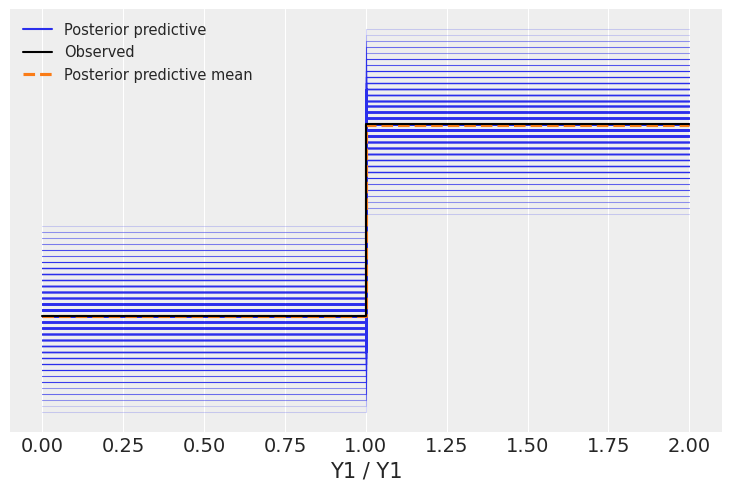

In [180]:
az.plot_ppc(FWI_pp)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

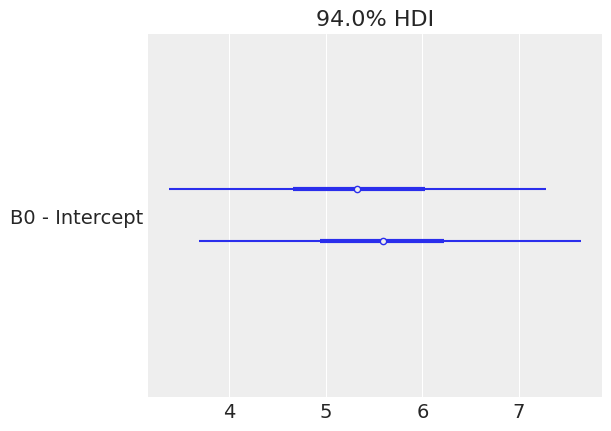

In [181]:
az.plot_forest(FWI_trace, var_names =['B0 - Intercept'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

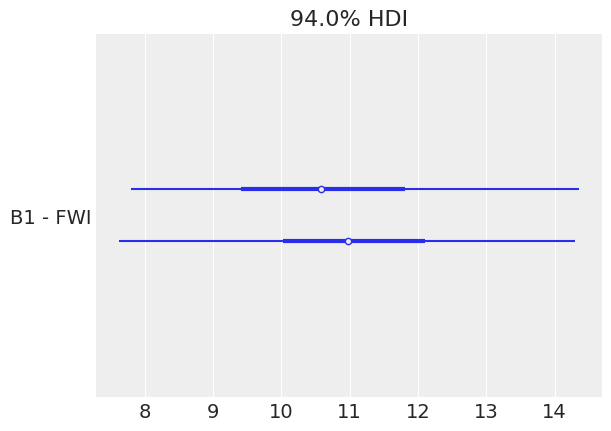

In [182]:
az.plot_forest(FWI_trace, var_names =['B1 - FWI'],)

## FWI Hierarchical

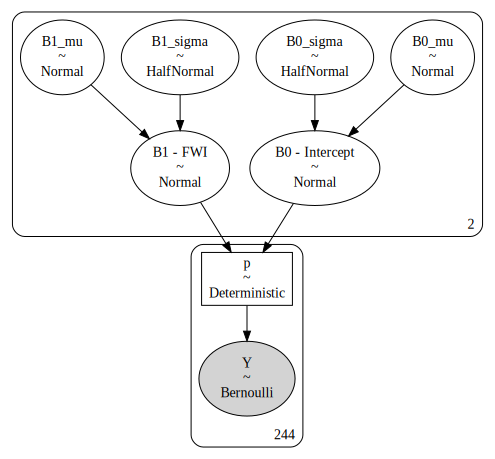

In [183]:
with pm.Model() as hierarchical_FWI_model:
    B0_mu = pm.Normal('B0_mu', mu=0, sigma=2, shape=num_regions)
    B0_sigma = pm.HalfNormal('B0_sigma', sigma=10, shape=num_regions)
    B0 = pm.Normal('B0 - Intercept', mu = B0_mu, sigma = B0_sigma, shape= num_regions)

    B1_mu = pm.Normal('B1_mu', mu=0, sigma=2, shape=num_regions)
    B1_sigma = pm.HalfNormal('B1_sigma', sigma=10, shape=num_regions)
    B1 = pm.Normal('B1 - FWI', mu = B1_mu, sigma = B1_sigma, shape= num_regions)

    eta = B0[region_ids] + B1[region_ids] * FWI
    p = pm.Deterministic('p', pm.invlogit(eta))

    Y = pm.Bernoulli('Y', p=p, observed = response_data)

pm.model_to_graphviz(hierarchical_FWI_model)

In [184]:
graph = pm.model_to_graphviz(hierarchical_FWI_model)
#graph.render(filename='path/to/exported/graph5', format='png')

In [185]:
with hierarchical_FWI_model:
    trace = pm.sample(random_seed = random_seed, return_inferencedata=False)
    H_FWI_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

In [186]:
az.summary(H_FWI_trace,  var_names =['B0 - Intercept','B1 - FWI'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
B0 - Intercept[0]   4.928  1.314   2.753    7.544      0.042    0.032   
B0 - Intercept[1]   5.406  1.484   2.793    8.004      0.055    0.041   
B1 - FWI[0]        10.405  2.289   6.556   15.012      0.073    0.054   
B1 - FWI[1]        10.329  2.451   6.217   14.900      0.089    0.066   

                   ess_bulk  ess_tail  r_hat  
B0 - Intercept[0]    1050.0    1000.0    1.0  
B0 - Intercept[1]     785.0     889.0    1.0  
B1 - FWI[0]          1062.0    1107.0    1.0  
B1 - FWI[1]           830.0     748.0    1.0

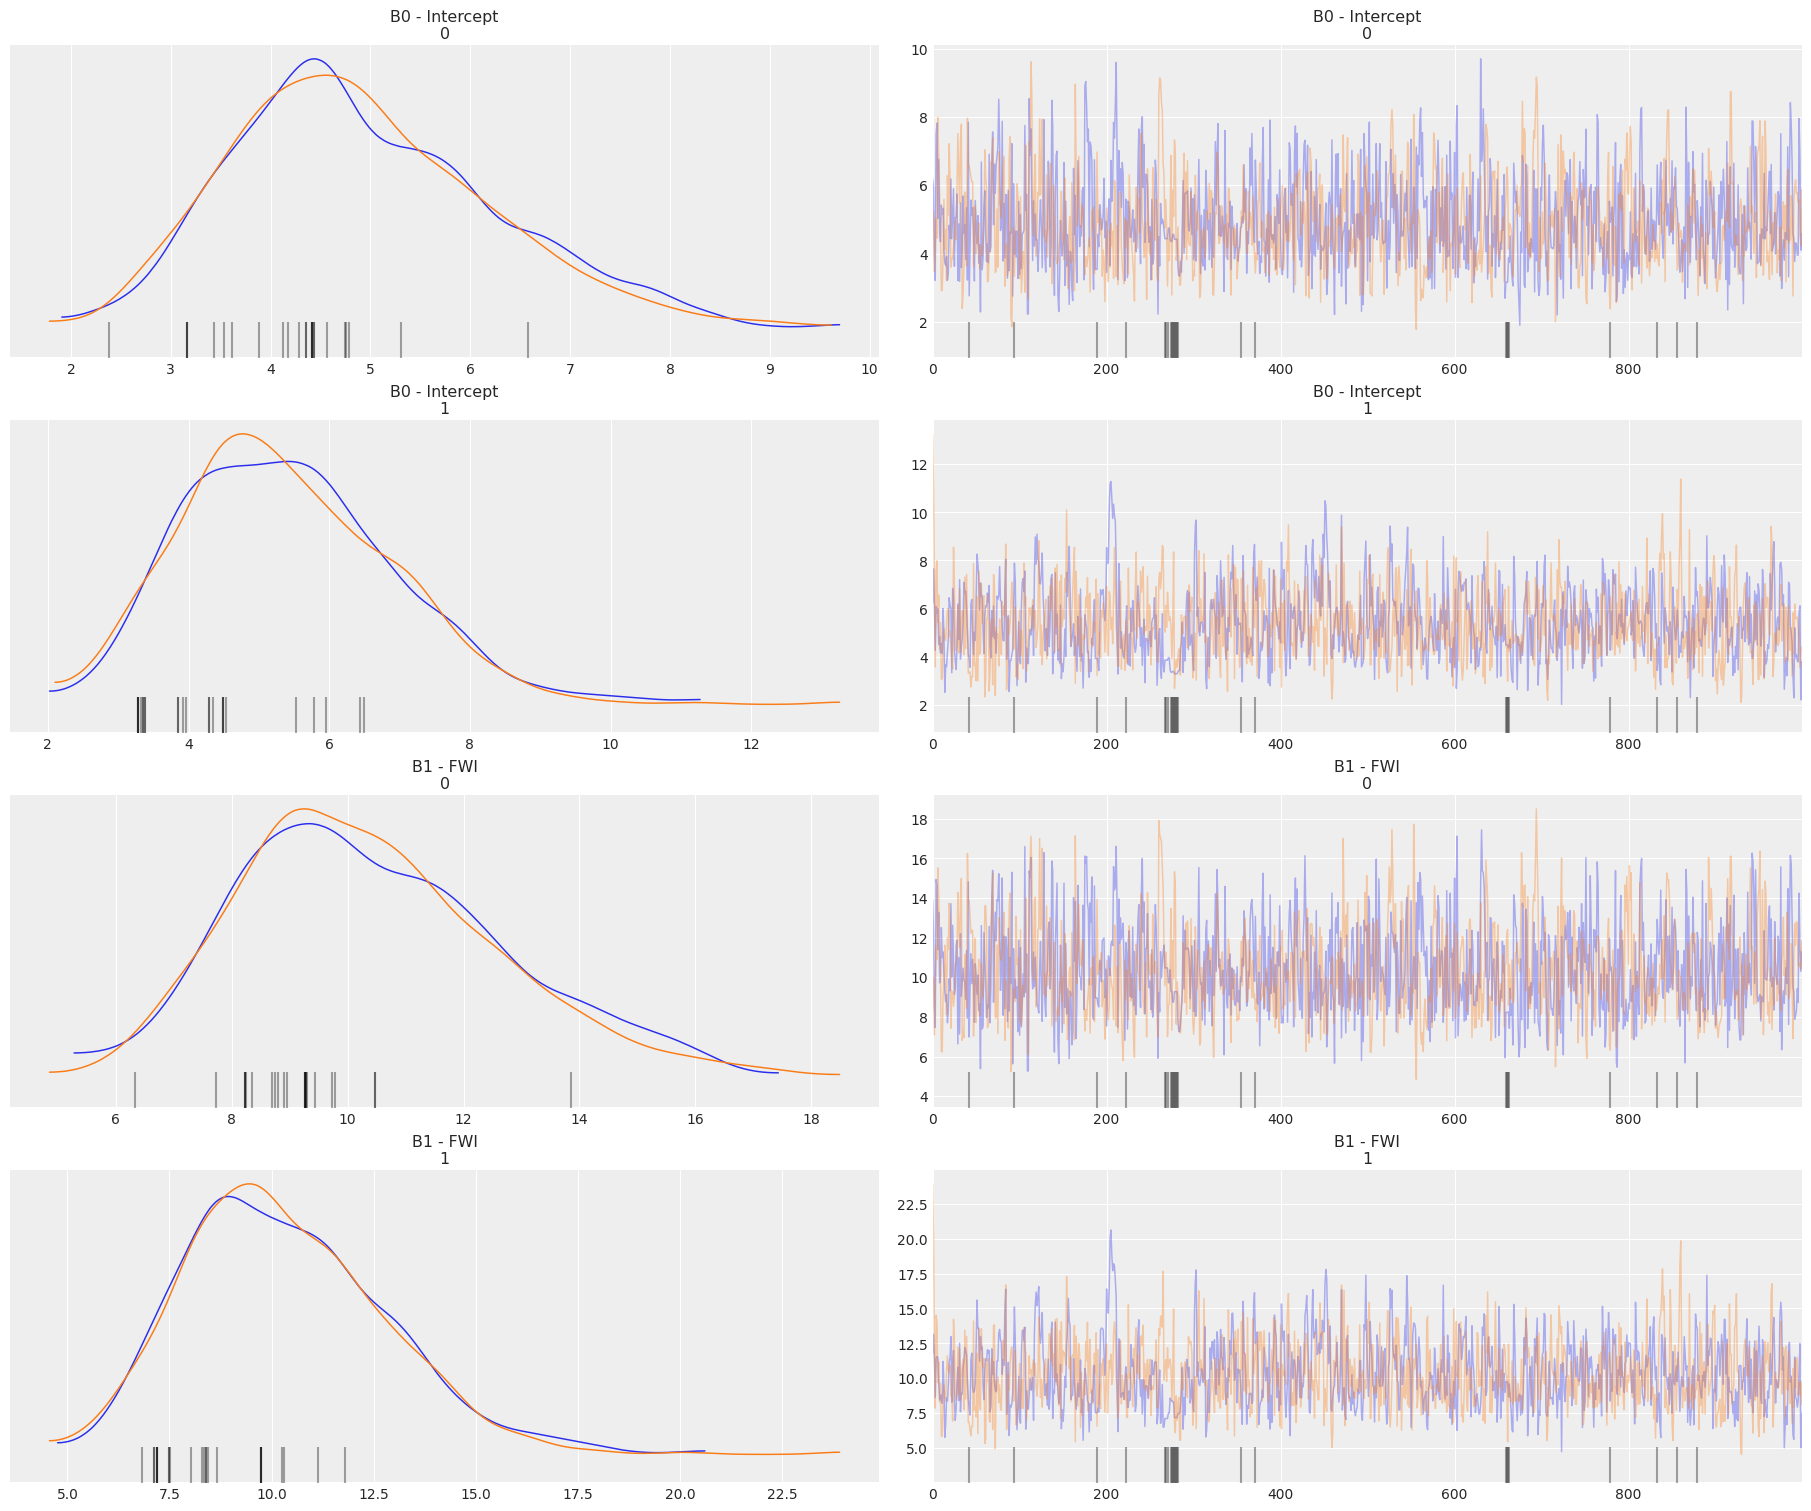

In [187]:
az.plot_trace(H_FWI_trace, compact = False, var_names =['B0 - Intercept','B1 - FWI'], figsize = (18,15));

<Axes: title={'center': 'Y / Y'}>

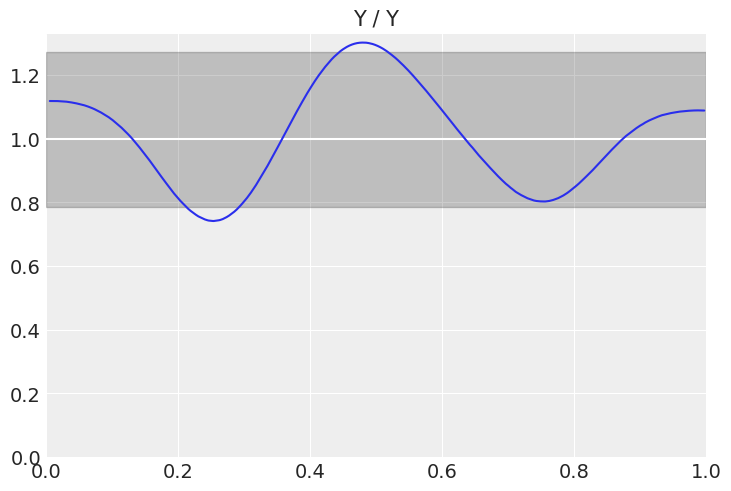

In [188]:
H_FWI_pp = pm.sample_posterior_predictive(H_FWI_trace,
                                           model = hierarchical_FWI_model,
                                           random_seed = random_seed)
az.plot_bpv(H_FWI_pp)

<Axes: xlabel='Y / Y'>

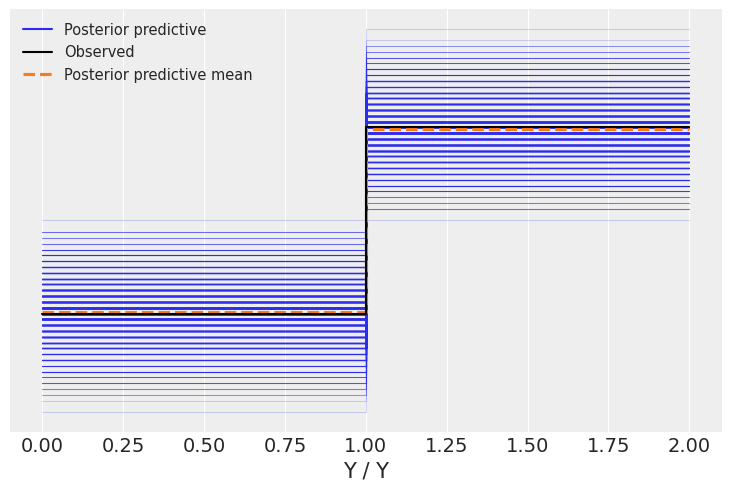

In [189]:
az.plot_ppc(H_FWI_pp)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

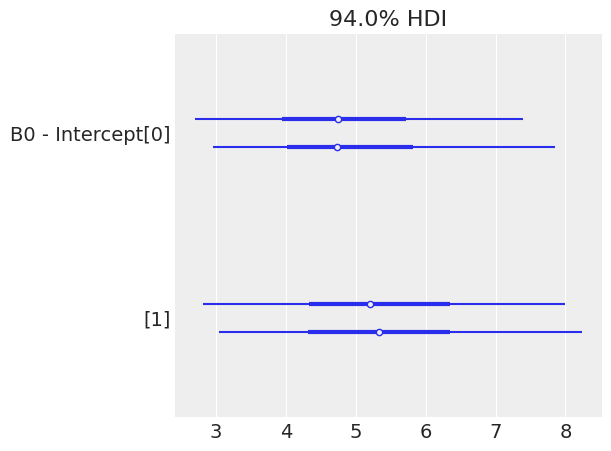

In [190]:
az.plot_forest(H_FWI_trace, var_names =['B0 - Intercept'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

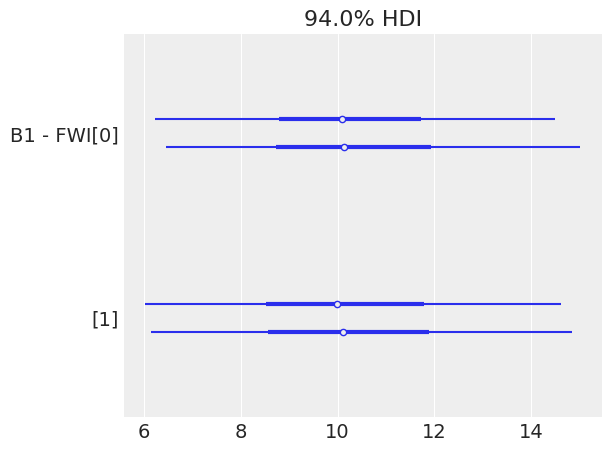

In [191]:
az.plot_forest(H_FWI_trace, var_names =['B1 - FWI'],)

We tried to build a hierarchical FIW model but find that the parameter estimates are almost identical between regions. Thus, we decide that the pooled FWI model makes more sense to use, as FWI is a standard code used globally. In addition, the interpretation of the measure will likely not vary too much by region as the code itself captures the measurements of rain, wind, humidity, and temperature.

## Findings

In [192]:
az.compare({'FWI':FWI_trace
           , 'Measurements (Hierarchical)':hierarchical_measurement_trace
            }
           , ic='waic')


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank  elpd_waic     p_waic  elpd_diff  weight  \
FWI                             0 -33.529165   1.965918   0.000000     1.0   
Measurements (Hierarchical)     1 -91.608953  15.667678  58.079787     0.0   

                                    se        dse  warning scale  
FWI                           6.840386   0.000000     True   log  
Measurements (Hierarchical)  12.248835  12.222914     True   log

We find that the pooled FWI model completely outperforms our hierarchical model. We will try to improve on our hierarchical model by building another hierarchical model with a non linear term.

## Hierarchical - non linear

In [193]:
fires2 = pd.read_csv('Algerian_forest_fires_dataset_UPDATE.csv', skiprows=1)
fires2.drop([122, 123], inplace=True)
fires2['Rain'] = pd.to_numeric(fires2['Rain '])
fires2['Rain_sqrt'] = np.sqrt(fires2['Rain'])
Rain_sqrt = fires2['Rain_sqrt'].values.reshape(-1, 1)
scaler = StandardScaler()
fires2['Rain_sqrt'] = scaler.fit_transform(Rain_sqrt)

In [194]:
Rain_sqrt = fires2['Rain_sqrt'].values

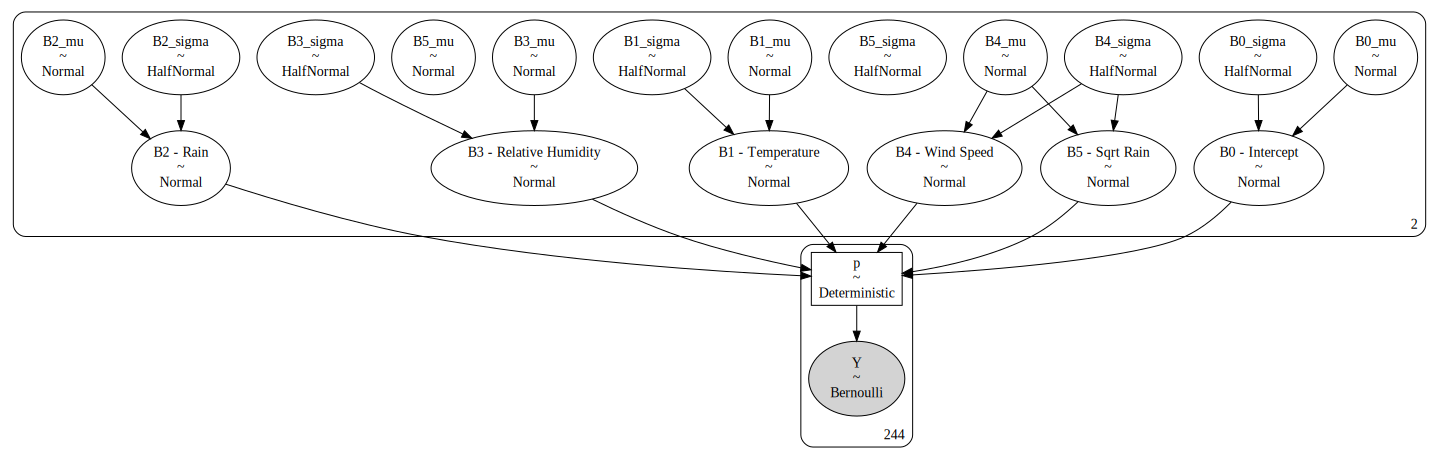

In [195]:
with pm.Model() as hierarchical_nonlin_measurement_model:
    B0_mu = pm.Normal('B0_mu', mu=0, sigma=2, shape=num_regions)
    B0_sigma = pm.HalfNormal('B0_sigma', sigma=10, shape=num_regions)
    B0 = pm.Normal('B0 - Intercept', mu = B0_mu, sigma = B0_sigma, shape= num_regions)

    B1_mu = pm.Normal('B1_mu', mu=0, sigma=2, shape=num_regions)
    B1_sigma = pm.HalfNormal('B1_sigma', sigma=10, shape=num_regions)
    B1 = pm.Normal('B1 - Temperature', mu = B1_mu, sigma = B1_sigma, shape= num_regions)

    B2_mu = pm.Normal('B2_mu', mu=0, sigma=2, shape=num_regions)
    B2_sigma = pm.HalfNormal('B2_sigma', sigma=10, shape=num_regions)
    B2 = pm.Normal('B2 - Rain', mu = B2_mu, sigma = B2_sigma, shape=num_regions)

    B3_mu = pm.Normal('B3_mu', mu=0, sigma=2, shape=num_regions)
    B3_sigma = pm.HalfNormal('B3_sigma', sigma=10, shape=num_regions)
    B3 = pm.Normal('B3 - Relative Humidity', mu = B3_mu, sigma = B3_sigma, shape=num_regions)

    B4_mu = pm.Normal('B4_mu', mu=0, sigma=2, shape=num_regions)
    B4_sigma = pm.HalfNormal('B4_sigma', sigma=10, shape=num_regions)
    B4 = pm.Normal('B4 - Wind Speed', mu = B4_mu, sigma = B4_sigma, shape=num_regions)

    B5_mu = pm.Normal('B5_mu', mu=0, sigma=2, shape=num_regions)
    B5_sigma = pm.HalfNormal('B5_sigma', sigma=10, shape=num_regions)
    B5 = pm.Normal('B5 - Sqrt Rain', mu = B4_mu, sigma = B4_sigma, shape=num_regions)

    eta = B0[region_ids] + B1[region_ids] * Temperature + B2[region_ids] * Rain + B3[region_ids] * RH + B4[region_ids] * Ws + B5[region_ids] * Rain_sqrt
    p = pm.Deterministic('p', pm.invlogit(eta))

    Y = pm.Bernoulli('Y', p=p, observed = response_data)

pm.model_to_graphviz(hierarchical_nonlin_measurement_model)

In [196]:
graph = pm.model_to_graphviz(hierarchical_nonlin_measurement_model)
#graph.render(filename='path/to/exported/graph6', format='png')

In [197]:
with hierarchical_nonlin_measurement_model:
    trace = pm.sample(random_seed = random_seed, return_inferencedata=False)
    hierarchical_nonlin_measurement_trace = pm.to_inference_data(trace=trace, log_likelihood=True)

In [198]:
az.summary(hierarchical_nonlin_measurement_trace,  var_names =['B0 - Intercept'
                                                              ,'B1 - Temperature'
                                                              ,'B2 - Rain'
                                                              ,'B3 - Relative Humidity'
                                                              ,'B4 - Wind Speed'
                                                              ,'B5 - Sqrt Rain'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
B0 - Intercept[0]         -2.628  1.658  -5.326   -0.158      0.079    0.058   
B0 - Intercept[1]          0.694  0.366   0.043    1.416      0.012    0.008   
B1 - Temperature[0]        1.495  0.588   0.458    2.647      0.023    0.021   
B1 - Temperature[1]        1.714  0.516   0.793    2.681      0.017    0.013   
B2 - Rain[0]              -3.124  6.055 -13.603    5.046      0.300    0.215   
B2 - Rain[1]               4.444  1.559   1.683    7.476      0.074    0.052   
B3 - Relative Humidity[0] -0.582  0.584  -1.679    0.436      0.025    0.018   
B3 - Relative Humidity[1] -1.442  0.518  -2.462   -0.493      0.018    0.013   
B4 - Wind Speed[0]         0.397  0.401  -0.387    1.135      0.015    0.010   
B4 - Wind Speed[1]         0.620  0.399  -0.112    1.373      0.013    0.009   
B5 - Sqrt Rain[0]         -5.677  1.809  -9.166   -2.200      0.079    0.056   
B5 - Sqrt Rain[1]         -5.980  1.485  -8.640   -3.284      0.072    0.051   

                           ess_bulk  ess_tail  r_hat  
B0 - Intercept[0]             587.0     490.0   1.00  
B0 - Intercept[1]            1014.0    1004.0   1.00  
B1 - Temperature[0]           754.0     282.0   1.00  
B1 - Temperature[1]           998.0     880.0   1.00  
B2 - Rain[0]                  541.0     431.0   1.00  
B2 - Rain[1]                  452.0     811.0   1.01  
B3 - Relative Humidity[0]     544.0    1052.0   1.00  
B3 - Relative Humidity[1]     870.0     863.0   1.01  
B4 - Wind Speed[0]            734.0     513.0   1.00  
B4 - Wind Speed[1]            971.0     927.0   1.00  
B5 - Sqrt Rain[0]             553.0     453.0   1.00  
B5 - Sqrt Rain[1]             384.0     417.0   1.01

In [199]:
az.summary(hierarchical_nonlin_measurement_trace)['r_hat'].max()

1.01

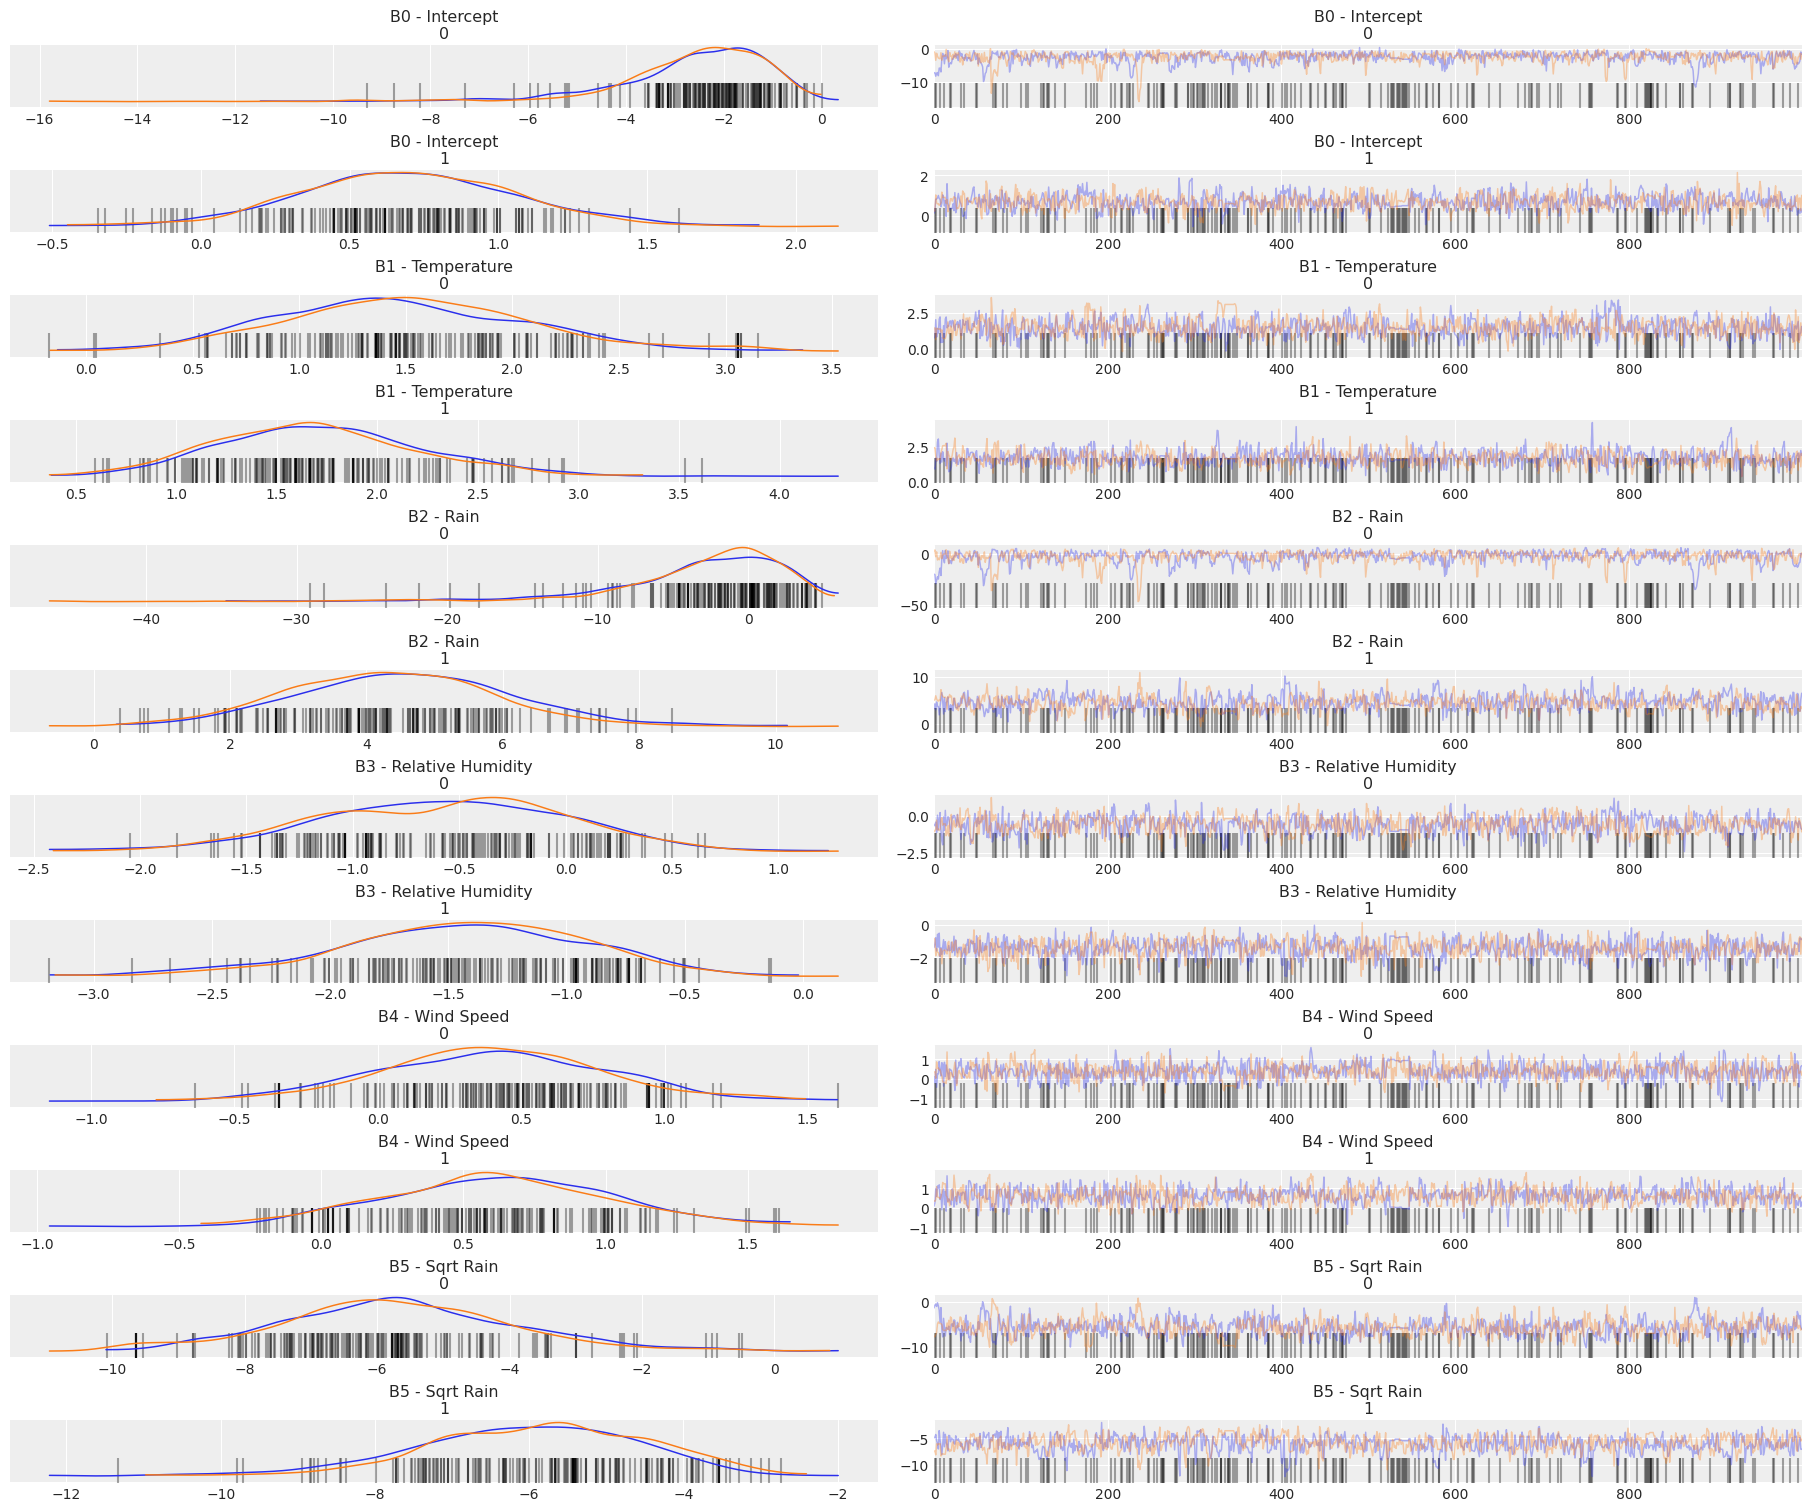

In [200]:
az.plot_trace(hierarchical_nonlin_measurement_trace, compact = False, var_names =['B0 - Intercept'
                                                              ,'B1 - Temperature'
                                                              ,'B2 - Rain'
                                                              ,'B3 - Relative Humidity'
                                                              ,'B4 - Wind Speed'
                                                              ,'B5 - Sqrt Rain']
              , figsize = (18,15));

<Axes: title={'center': 'Y / Y'}>

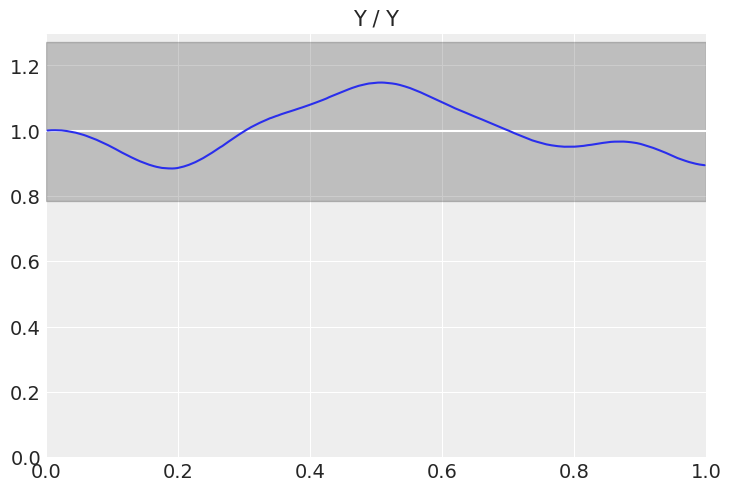

In [201]:
hierarchical_nonlin_measurement_pp = pm.sample_posterior_predictive(hierarchical_nonlin_measurement_trace,
                                           model = hierarchical_nonlin_measurement_model,
                                           random_seed = random_seed)
az.plot_bpv(hierarchical_nonlin_measurement_pp)

<Axes: xlabel='Y / Y'>

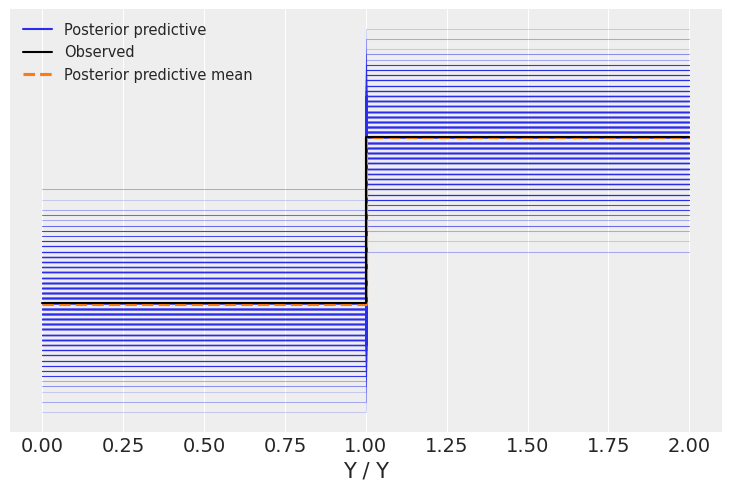

In [202]:
az.plot_ppc(hierarchical_nonlin_measurement_pp)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

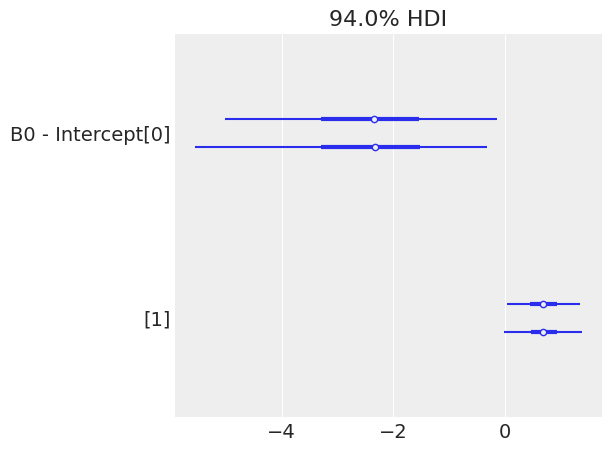

In [203]:
az.plot_forest(hierarchical_nonlin_measurement_trace, var_names =['B0 - Intercept'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

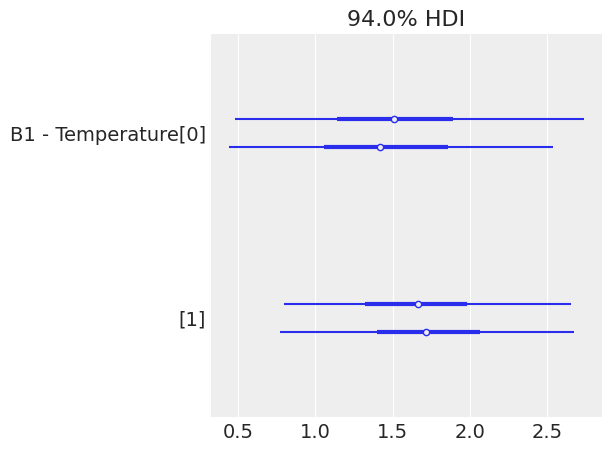

In [204]:
az.plot_forest(hierarchical_nonlin_measurement_trace, var_names =['B1 - Temperature'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

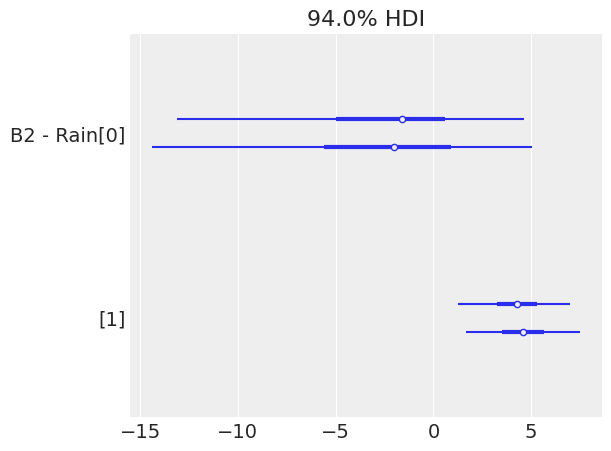

In [205]:
az.plot_forest(hierarchical_nonlin_measurement_trace, var_names =['B2 - Rain'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

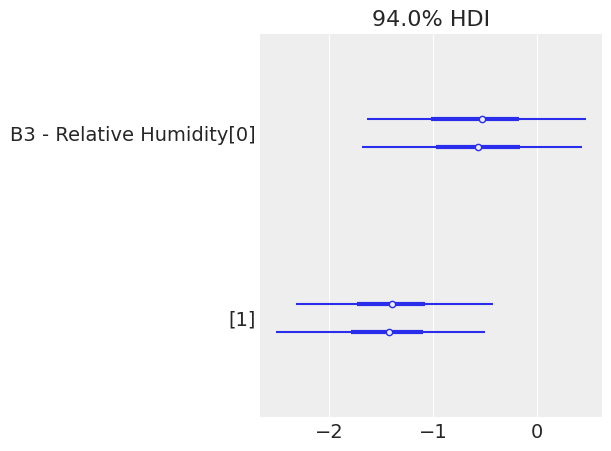

In [206]:
az.plot_forest(hierarchical_nonlin_measurement_trace, var_names =['B3 - Relative Humidity'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

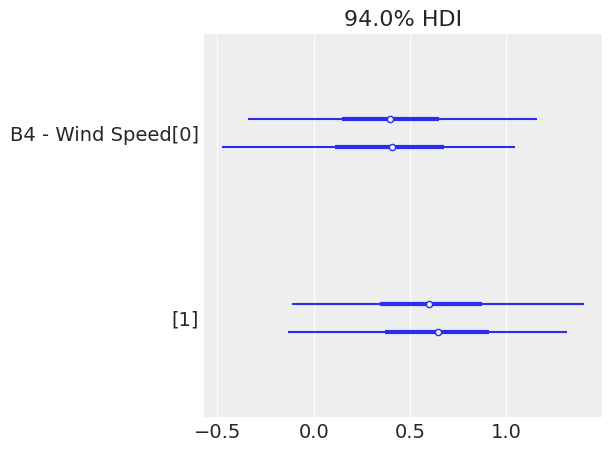

In [207]:
az.plot_forest(hierarchical_nonlin_measurement_trace, var_names =['B4 - Wind Speed'],)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

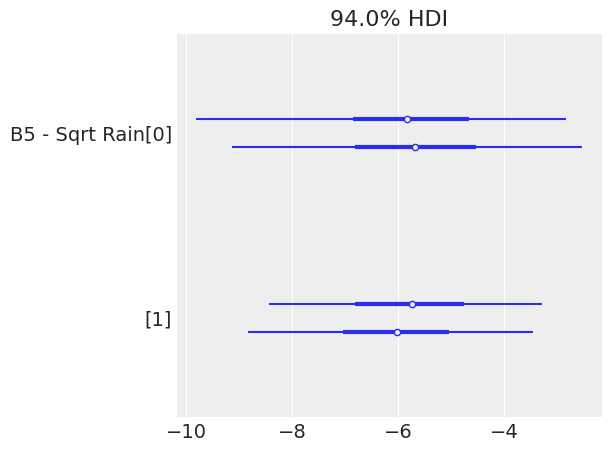

In [208]:
az.plot_forest(hierarchical_nonlin_measurement_trace, var_names =['B5 - Sqrt Rain'],)

## Findings part 2

In [210]:
az.compare({'Measurements (Linear Hierarchical)':hierarchical_measurement_trace
           , 'Measurements (Nonlinear Hierarchical)':hierarchical_nonlin_measurement_trace
            }
           , ic='waic')


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank  elpd_waic     p_waic  elpd_diff  \
Measurements (Nonlinear Hierarchical)     0 -73.970674  12.796222   0.000000   
Measurements (Linear Hierarchical)        1 -91.608953  15.667678  17.638278   

                                         weight         se       dse  warning  \
Measurements (Nonlinear Hierarchical)  0.928203  11.007026  0.000000     True   
Measurements (Linear Hierarchical)     0.071797  12.248835  8.590121     True   

                                      scale  
Measurements (Nonlinear Hierarchical)   log  
Measurements (Linear Hierarchical)      log

In [211]:
az.compare({'FWI (Pooled)':FWI_trace
           , 'Measurements (Nonlinear Hierarchical)':hierarchical_nonlin_measurement_trace
            }
           , ic='waic')


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank  elpd_waic     p_waic  elpd_diff  \
FWI (Pooled)                              0 -33.529165   1.965918   0.000000   
Measurements (Nonlinear Hierarchical)     1 -73.970674  12.796222  40.441509   

                                         weight         se        dse  \
FWI (Pooled)                           0.937411   6.840386   0.000000   
Measurements (Nonlinear Hierarchical)  0.062589  11.007026  11.942987   

                                       warning scale  
FWI (Pooled)                              True   log  
Measurements (Nonlinear Hierarchical)     True   log

Our non linear hierarchical model with a square root transformation of rain seems to be better than our linear hierarchical model, with a model weight of 6.4% compared to almost 0%. Although we improved our model, it is safe to say that the Fire Weather Index is the best predictor of fires that combines all of the predictors that we have used in our models.

# Appendix Code

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

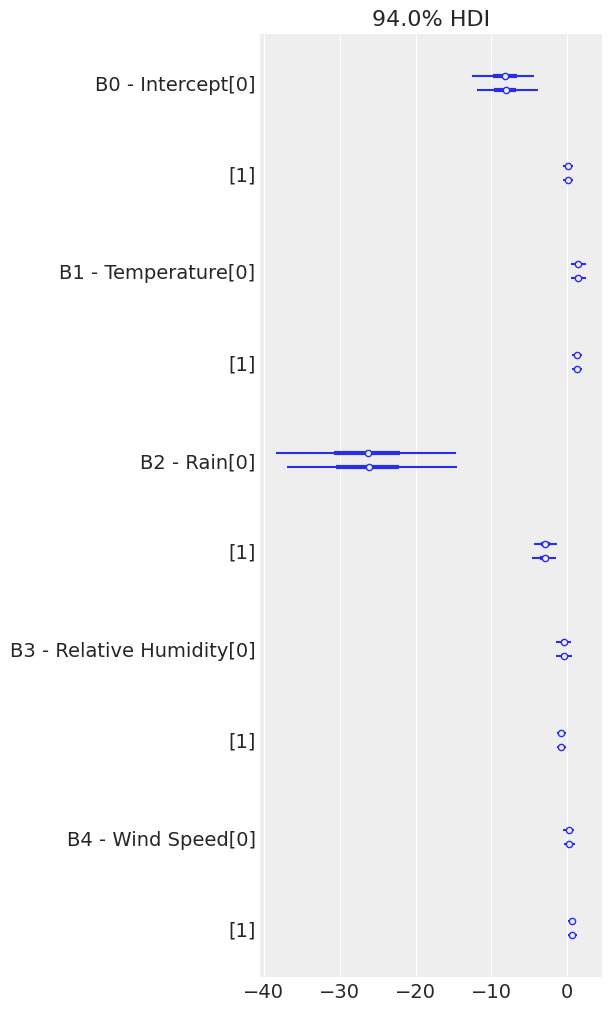

In [213]:
az.plot_forest(hierarchical_measurement_trace, var_names =['B0 - Intercept'
,'B1 - Temperature'
,'B2 - Rain'
, 'B3 - Relative Humidity'
, 'B4 - Wind Speed'],)


In [ ]:
num_regions = len(fires['region'].unique())
region_unique = fires['region'].unique()
response_data = fires['Classes_binary'].values

In [ ]:
continuous_cols = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
scaler = StandardScaler()
fires[continuous_cols] = scaler.fit_transform(fires[continuous_cols])

In [ ]:
fires.columns

Index(['day', 'month', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC',
       'ISI', 'BUI', 'FWI', 'Classes', 'region', 'region_dummy',
       'Classes_binary', 'FFMC_log'],
      dtype='object')

In [ ]:
month = fires['month'].values
Temperature = fires['Temperature'].values
RH = fires['RH'].values
Ws = fires['Ws'].values
Rain = fires['Rain'].values
FFMC = fires['FFMC'].values
DMC = fires['DMC'].values
DC = fires['DC'].values
ISI = fires['ISI'].values
BUI = fires['BUI'].values
FWI = fires['FWI'].values

<ipython-input-360-5f7fd4595b39>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=fires[fires['Classes_binary']==1], x='Ws', bins=30, palette="viridis")


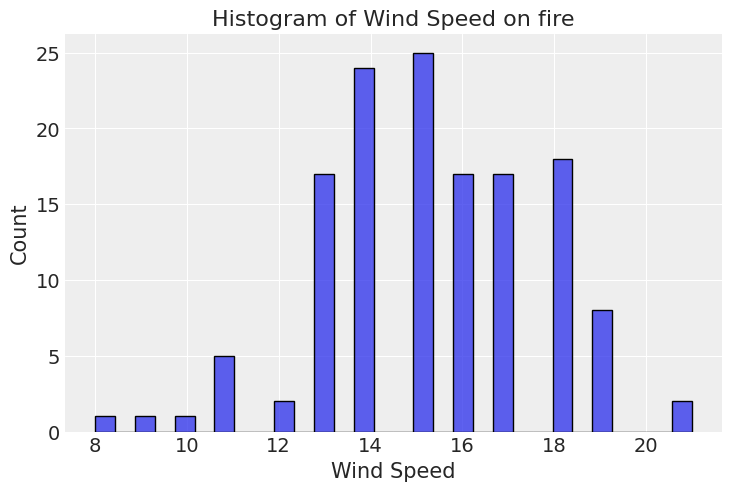

In [ ]:
# Replace 'binary outcome' and 'wind speed' with your actual column names
sns.histplot(data=fires[fires['Classes_binary']==1], x='Ws', bins=30, palette="viridis")

plt.title('Histogram of Wind Speed on fire')
plt.xlabel('Wind Speed')
plt.ylabel('Count')

plt.show()


<ipython-input-361-4a86575efebe>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=fires[fires['Classes_binary']==0], x='Ws', bins=30, palette="viridis")


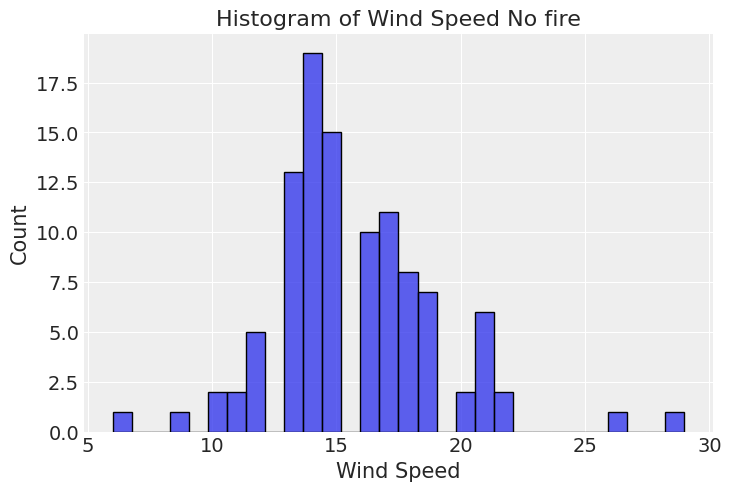

In [ ]:
# Replace 'binary outcome' and 'wind speed' with your actual column names
sns.histplot(data=fires[fires['Classes_binary']==0], x='Ws', bins=30, palette="viridis")

plt.title('Histogram of Wind Speed No fire')
plt.xlabel('Wind Speed')
plt.ylabel('Count')

plt.show()


### Model 1 - Pooled model

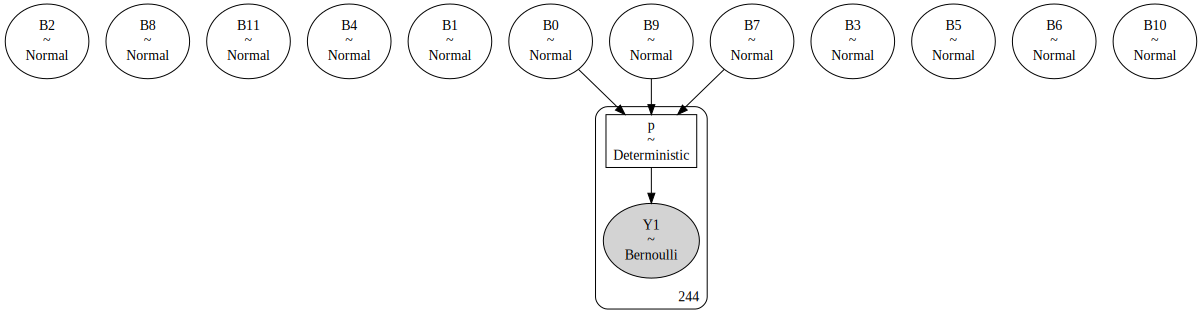

In [ ]:
#best with extra predictors
with pm.Model() as pooled_model_2:
  B0 = pm.Normal('B0', mu = 0, sigma = 10)
  B1 = pm.Normal('B1', mu = 0, sigma = 10)
  B2 = pm.Normal('B2', mu = 0, sigma = 10)
  B3 = pm.Normal('B3', mu = 0, sigma = 10)
  B4 = pm.Normal('B4', mu = 0, sigma = 10)
  B5 = pm.Normal('B5', mu = 0, sigma = 10)
  B6 = pm.Normal('B6', mu = 0, sigma = 10)
  B7 = pm.Normal('B7', mu = 0, sigma = 10)
  B8 = pm.Normal('B8', mu = 0, sigma = 10)
  B9 = pm.Normal('B9', mu = 0, sigma = 10)
  B10 = pm.Normal('B10', mu = 0, sigma = 10)
  B11 = pm.Normal('B11', mu = 0, sigma = 10)

  eta = B0 + B7 * BUI + B9 * ISI
  p = pm.Deterministic('p', pm.invlogit(eta))
  Y1 = pm.Bernoulli('Y1', p = p, observed = response_data)

pm.model_to_graphviz(pooled_model_2)

In [ ]:
# BEST SIMPLE MODEL
with pm.Model() as pooled_measurement_model:
  B0 = pm.Normal('B0', mu = 0, sigma = 10)
  B1 = pm.Normal('B1', mu = 0, sigma = 10)
  B2 = pm.Normal('B2', mu = 0, sigma = 10)
  B3 = pm.Normal('B3', mu = 0, sigma = 10)
  B4 = pm.Normal('B4', mu = 0, sigma = 10)
  B5 = pm.Normal('B5', mu = 0, sigma = 10)
  B6 = pm.Normal('B6', mu = 0, sigma = 10)
  B7 = pm.Normal('B7', mu = 0, sigma = 10)
  B8 = pm.Normal('B8', mu = 0, sigma = 10)
  B9 = pm.Normal('B9', mu = 0, sigma = 10)
  B10 = pm.Normal('B10', mu = 0, sigma = 10)
  B11 = pm.Normal('B11', mu = 0, sigma = 10)

  eta = B0 + B1 * Temperature + B2 * Rain + B3 * RH + B4 * Ws
  p = pm.Deterministic('p', pm.invlogit(eta))
  Y1 = pm.Bernoulli('Y1', p = p, observed = response_data)

pm.model_to_graphviz(pooled_model)

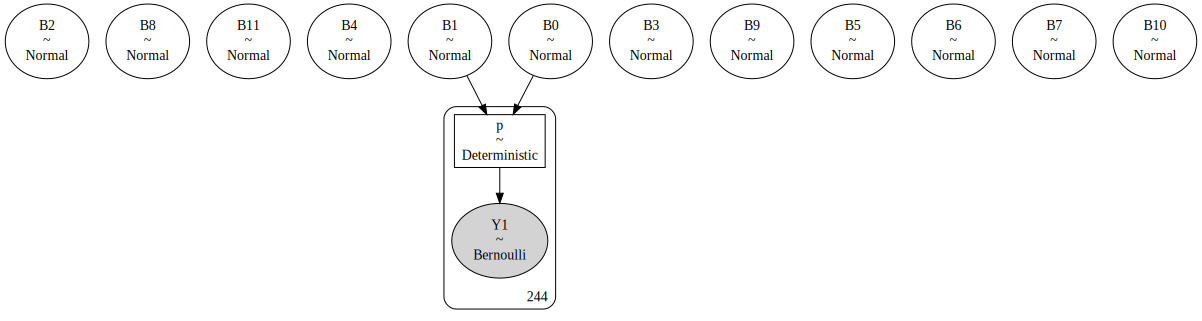

In [ ]:
#Just FWI
with pm.Model() as pooled_FWI_model:
  B0 = pm.Normal('B0', mu = 0, sigma = 10)
  B1 = pm.Normal('B1', mu = 0, sigma = 10)
  B2 = pm.Normal('B2', mu = 0, sigma = 10)
  B3 = pm.Normal('B3', mu = 0, sigma = 10)
  B4 = pm.Normal('B4', mu = 0, sigma = 10)
  B5 = pm.Normal('B5', mu = 0, sigma = 10)
  B6 = pm.Normal('B6', mu = 0, sigma = 10)
  B7 = pm.Normal('B7', mu = 0, sigma = 10)
  B8 = pm.Normal('B8', mu = 0, sigma = 10)
  B9 = pm.Normal('B9', mu = 0, sigma = 10)
  B10 = pm.Normal('B10', mu = 0, sigma = 10)
  B11 = pm.Normal('B11', mu = 0, sigma = 10)

  eta = B0 + B1 * FWI
  p = pm.Deterministic('p', pm.invlogit(eta))
  Y1 = pm.Bernoulli('Y1', p = p, observed = response_data)

pm.model_to_graphviz(pooled_FWI_model)

In [ ]:
with pm.Model() as FWI_hierarchical_model:
    B0_mu = pm.Normal('B0_mu', mu=0, sigma=2, shape=num_regions)
    B0_sigma = pm.HalfNormal('B0_sigma', sigma=10, shape=num_regions)
    B0 = pm.Normal('B0', mu = B0_mu, sigma = B0_sigma, shape= num_regions)

    B1_mu = pm.Normal('B1_mu', mu=0, sigma=2, shape=num_regions)
    B1_sigma = pm.HalfNormal('B1_sigma', sigma=10, shape=num_regions)
    B1 = pm.Normal('B1', mu = B1_mu, sigma = B1_sigma, shape= num_regions)

    eta = B0[region_ids] + B1[region_ids] * FWI
    p = pm.Deterministic('p', pm.invlogit(eta))

    Y = pm.Bernoulli('Y', p=p, observed = response_data)

pm.model_to_graphviz(FWI_hierarchical_model)

In [ ]:
with pooled_FWI_model:
    trace_fwi = pm.sample(random_seed = random_seed, return_inferencedata=False)
    pooled_trace_fwi = pm.to_inference_data(trace=trace_fwi, log_likelihood=True)

In [ ]:
with pooled_measurement_model:
    trace_measure = pm.sample(random_seed = random_seed, return_inferencedata=False)
    pooled_trace_measure = pm.to_inference_data(trace=trace_measure, log_likelihood=True)


In [ ]:
with pooled_model_2:
    trace_ISI = pm.sample(random_seed = random_seed, return_inferencedata=False)
    pooled_trace_ISI = pm.to_inference_data(trace=trace_ISI, log_likelihood=True)

In [ ]:
cmp_df = az.compare({'BUI and ISI':pooled_trace_ISI, 'fwi':pooled_trace_fwi}, ic='waic')
cmp_df

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank  elpd_waic    p_waic  elpd_diff        weight        se  \
BUI and ISI     0 -12.595910  1.436050   0.000000  1.000000e+00  3.047166   
fwi             1 -33.604476  2.055086  21.008565  1.392664e-12  6.881938   

                 dse  warning scale  
BUI and ISI  0.00000    False   log  
fwi          5.88203     True   log

In [ ]:
pooled_pp = pm.sample_posterior_predictive(pooled_trace,
                                           model = pooled_model_2,
                                           random_seed = random_seed)
az.plot_bpv(pooled_pp)

In [ ]:
#Best for comparison
#pooled_pp = pm.sample_posterior_predictive(pooled_trace,
#                                           model = pooled_model_2,
#                                           random_seed = random_seed)
#az.plot_bpv(pooled_pp)

In [ ]:
az.plot_ppc(pooled_pp)

In [ ]:
az.plot_posterior(
    pooled_trace,
    var_names= ['B0', 'B1','B2', 'B3','B4'], ref_val = 0
);

In [ ]:
az.plot_posterior(
    pooled_trace,
    var_names= ['B0', 'B1','B2', 'B3','B4', 'B5'], ref_val = 0
);

In [ ]:
az.plot_trace(pooled_trace, kind = "rank_bars")

### Model 2 - Unpooled model

In [ ]:
with pm.Model() as unpooled_model:
    B0 = pm.Normal('B0', mu=0, sigma=10, shape=num_regions)
    B1 = pm.Normal('B1', mu=0, sigma=10, shape=num_regions)
    B0 = pm.Normal('B0', mu = 0, sigma = 10, shape=num_regions)
    B1 = pm.Normal('B1', mu = 0, sigma = 10, shape=num_regions)
    B2 = pm.Normal('B2', mu = 0, sigma = 10, shape=num_regions)
    B3 = pm.Normal('B3', mu = 0, sigma = 10, shape=num_regions)
    B4 = pm.Normal('B4', mu = 0, sigma = 10, shape=num_regions)
    B5 = pm.Normal('B5', mu = 0, sigma = 10, shape=num_regions)
    B6 = pm.Normal('B6', mu = 0, sigma = 10, shape=num_regions)
    B7 = pm.Normal('B7', mu = 0, sigma = 10, shape=num_regions)
    B8 = pm.Normal('B8', mu = 0, sigma = 10, shape=num_regions)
    B9 = pm.Normal('B9', mu = 0, sigma = 10, shape=num_regions)
    B10 = pm.Normal('B10', mu = 0, sigma = 10, shape=num_regions)
    B11 = pm.Normal('B11', mu = 0, sigma = 10, shape=num_regions)

    eta = B0[region_ids] + B1[region_ids] * month + B2[region_ids] * Temperature + B3[region_ids] * RH + B4[region_ids] * Ws + B5[region_ids] * Rain + B6[region_ids] * FFMC + B7[region_ids] * DMC + B8[region_ids] * DC + B9[region_ids] * ISI + B10[region_ids] * BUI + B11[region_ids] * FWI
    p = pm.Deterministic('p', pm.invlogit(eta))

    Y = pm.Bernoulli('Y', p=p, observed = response_data)

pm.model_to_graphviz(unpooled_model)

### Model 3 - Hierarchical model

In [ ]:
with pm.Model() as hierarchical_model:
    B0_mu = pm.Normal('B0_mu', mu=0, sigma=10, shape=num_regions)
    B0_sigma = pm.HalfNormal('B0_sigma', sigma=10, shape=num_regions)
    B0 = pm.Normal('B0', mu=B0_mu[region_unique], sigma=B0_sigma[region_unique], shape=num_regions)

    B1_mu = pm.Normal('B1_mu', mu=0, sigma=10, shape=num_regions)
    B1_sigma = pm.HalfNormal('B1_sigma', sigma=10, shape=num_regions)
    B1 = pm.Normal('B1', mu=B1_mu[region_unique], sigma=B1_sigma[region_unique], shape=num_regions)

    eta = B0[num_regions] + B1[num_regions] * age_centered
    p = pm.Deterministic('p', pm.invlogit(eta))

    Y = pm.Bernoulli('Y', p = p, observed = response_data)

pm.model_to_graphviz(hierarchical_model)

### Model 4 - Non-linear model